In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModelTimeStep
from deep_macrofin import ActivationType, OptimizerType, Comparator, SamplingMethod, plot_loss_df, set_seeds

In [4]:
latex_var_map = {
    r"J_e": "Je",
    r"J_h": "Jh",
    r"\psi": "psi",
    r"\iota": "iota",
    r"\Phi": "Phi",
    r"\hat{c}_e": "ce",
    r"\hat{c}_h": "ch",

    r"\mu_{ae}": "muae",
    r"\sigma_{ae}": "sigae",
    r"\theta_e": "thetae",
    r"\theta_h": "thetah",
    r"\sigma^{q,k}": "sigqk",
    r"\sigma^{q,a}": "sigqa",
    r"\sigma^{q,k,1}": "sigsigqk",
    r"\sigma^{z,k}": "sigzk",
    r"\sigma^{z,a}": "sigza",
    r"\sigma_e^{J,k}": "sigJe_k",
    r"\sigma_h^{J,k}": "sigJh_k",
    r"\sigma_e^{J,a}": "sigJe_a",
    r"\sigma_h^{J,a}": "sigJh_a",

    r"\zeta_e^k": "zetae_k",
    r"\zeta_e^a": "zetae_a",
    r"\zeta_h^k": "zetah_k",
    r"\zeta_h^a": "zetah_a",
    r"\zeta_e^1": "zetae_1",
    r"\zeta_e^2": "zetae_2",
    r"\zeta_h^1": "zetah_1",
    r"\zeta_h^2": "zetah_2",
    r"\epsilon_e": "epse",
    r"\epsilon_h": "epsh",

    r"\mu^z": "muz",
    r"\mu^q": "muq",
    r"\mu_e^J": "muJe",
    r"\mu_h^J": "muJh",
    r"\mu_e^R": "muRe",
    r"\mu_h^R": "muRh",

    r"\hat{a_e}": "aebar",
    r"a_e": "ae",
    r"a_h": "ah",
    r"\sigma": "sig",
    r"\delta": "delta",
    r"\kappa": "kappa",
    r"\phi": "phi",
    r"\gamma": "gamma",
    r"\rho": "rho",
    r"\lambda_d": "lambdad",
    r"\underline{\chi}": "chi_a",
    r"\chi": "chi",
    r"\bar{z}": "zbar",
}

vars_to_plot = ["q", "thetae", "thetah", "psi", "sigsigqk", "sigqa", "epse", "epsh",
                "zmuz", "zsigzk", "zsigza", "zetae_k", "zetae_a", "zetah_k", "zetah_a"]
plot_args = {
    "q": {"ylabel": r"$q$", "title": r"Price"},
    "thetae": {"ylabel": r"$\theta_e$", "title": r"Portfolio Choice: Experts"},
    "thetah": {"ylabel": r"$\theta_h$", "title": r"Portfolio Choice: Households"},
    "psi": {"ylabel": r"$\psi$", "title": r"Capital Share: Experts"},
    "sigsigqk": {"ylabel": r"$\sigma+\sigma^{q,k}$", "title": r"Price return diffusion (capital shock)"},
    "sigqa": {"ylabel": r"$\sigma^{q,a}$", "title": r"Price return diffusion (productivity shock)"},
    "zmuz": {"ylabel": r"$z\mu^z$", "title": r"Drift of wealth share: Experts"},
    "zsigzk": {"ylabel": r"$z\sigma^{z,k}$", "title": r"Diffusion of wealth share (capital shock)"},
    "zsigza": {"ylabel": r"$z\sigma^{z,a}$", "title": r"Diffusion of wealth share (productivity shock)"},
    "zetae_k": {"ylabel": r"$\zeta_e^k$", "title": r"Experts price of risk: capital shock"},
    "zetae_a": {"ylabel": r"$\zeta_e^a$", "title": r"Experts price of risk: productivity shock"},
    "zetah_k": {"ylabel": r"$\zeta_h^k$", "title": r"Households price of risk: capital shock"},
    "zetah_a": {"ylabel": r"$\zeta_h^a$", "title": r"Households price of risk: productivity shock"}
}

z_min = 0.01
z_max = 0.99
a_min = 0.1
a_max = 0.2
ae_bar = (a_min + a_max) / 2
a_list = [a_min, ae_bar, a_max]
params = {
    "ah": 0.03,
    "sig": 0.1,
    "delta": 0.05,
    "kappa": 5,
    "phi": 0.5,
    "gamma": 5,
    "rho": torch.tensor(0.05),
    "lambdad": 0.03,
    "zbar": 0.1,
    "chi_a": 1,
    "v": 2.5,
    "p": 0.01,
    "fl": a_min,
    "fu": a_max,
    "aebar": ae_bar,
}

base_model_dir = "./models/cd_2d_timestep/"

In [5]:
def compute_func(pde_model: PDEModelTimeStep, a_list, z_min, z_max, vars_to_plot):
    N = 100
    res_dict = {}
    for a in a_list:
        SV = torch.zeros((N, 3), device=pde_model.device)
        SV[:, 0] = torch.linspace(z_min, z_max, N)
        SV[:, 1] = torch.ones((N,)) * a
        x_plot = SV[:, 0].detach().cpu().numpy().reshape(-1)
        for i, sv_name in enumerate(pde_model.state_variables):
            pde_model.variable_val_dict[sv_name] = SV[:, i:i+1]
        pde_model.update_variables(SV)
        res_dict["x_plot"] = x_plot
        for var in vars_to_plot:
            if var in pde_model.variable_val_dict:
                res_dict[f"{var}_{a}"] = pde_model.variable_val_dict[var].detach().cpu().numpy().reshape(-1)
            elif var == "psi":
                res_dict[f"psi_{a}"] = np.ones(N)
    return res_dict

def plot_res(res_dict: dict, plot_args:dict, a_list):
    res_dict = res_dict.copy()
    x_plot = res_dict.pop("x_plot")
    x_label = "Wealth share (z)"
    total_plots = len(plot_args)
    cols = 4
    rows, rem = np.divmod(total_plots, cols)
    if rem > 0:
        rows += 1

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6, rows*6))
    for i, (func_name, plot_arg) in enumerate(plot_args.items()):
        r, c = np.divmod(i, cols)
        curr_ax = axes[r, c] # hopefully we don't have only one row...
        for a in a_list:
            y_vals = res_dict[f"{func_name}_{a}"]
            curr_ax.plot(x_plot, y_vals, label=r"$a_e$={i}".format(i=str(round(a,2))))
        curr_ax.set_xlabel(x_label)
        curr_ax.set_ylabel(plot_arg["ylabel"])
        curr_ax.set_title(plot_arg["title"])
        curr_ax.legend()
    plt.show()

## Region 1
$\psi < 1$

============================Summary of Model cd2d_ts============================
Config: {
 "batch_size": 20,
 "num_outer_iterations": 50,
 "num_inner_iterations": 5000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001
}
Latex Variable Mapping:
{
 "J_e": "Je",
 "J_h": "Jh",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "Phi",
 "\\hat{c}_e": "ce",
 "\\hat{c}_h": "ch",
 "\\mu_{ae}": "muae",
 "\\sigma_{ae}": "sigae",
 "\\theta_e": "thetae",
 "\\theta_h": "thetah",
 "\\sigma^{q,k}": "sigqk",
 "\\sigma^{q,a}": "sigqa",
 "\\sigma^{q,k,1}": "sigsigqk",
 "\\sigma^{z,k}": "sigzk",
 "\\sigma^{z,a}": "sigza",
 "\\sigma_e^{J,k}": "sigJe_k",
 "\\sigma_h^{J,k}": "sigJh_k",
 "\\sigma_e^{J,a}": "sigJe_a",
 "\\sigma_h^{J,a}": "sigJh_a",
 "\\zeta_e^k": "zetae_k",
 "\\zeta_e^a": "zetae_a",
 "\\zeta_h^k": "zetah_k",
 "\\zeta_h^a": "zetah_a",
 "\\zeta_e^1": "zetae_1",
 "\\zeta_e^2": "zetae_2",
 "\\zeta_h^1": "zetah_1",

Total loss: 0.0019: 100%|██████████| 5000/5000 [17:34<00:00,  4.74it/s]


Model loaded
Je: Mean Value: 0.83333, Absolute Change: 0.16667, Relative Change:  0.16667
Jh: Mean Value: 0.83139, Absolute Change: 0.16861, Relative Change:  0.16861
q: Mean Value: 1.39530, Absolute Change: 0.40230, Relative Change:  0.40230
psi: Mean Value: 1.05833, Absolute Change: 0.39406, Relative Change:  0.39406
Updating min loss from inf to 0.0019
Outer Loop 0 Finished in 1054.3101s. Loading best model...


Total loss: 0.0003: 100%|██████████| 3535/3535 [12:43<00:00,  4.63it/s]


Model loaded
Je: Mean Value: 0.70758, Absolute Change: 0.12576, Relative Change:  0.15573
Jh: Mean Value: 0.70214, Absolute Change: 0.12925, Relative Change:  0.15643
q: Mean Value: 1.39229, Absolute Change: 0.01242, Relative Change:  0.00884
psi: Mean Value: 1.03846, Absolute Change: 0.02233, Relative Change:  0.02084
Updating min loss from 0.0019 to 0.0002
Outer Loop 1 Finished in 763.4825s. Loading best model...


Total loss: 0.0002: 100%|██████████| 2886/2886 [10:07<00:00,  4.75it/s]


Model loaded
Je: Mean Value: 0.60860, Absolute Change: 0.09897, Relative Change:  0.14727
Jh: Mean Value: 0.59922, Absolute Change: 0.10292, Relative Change:  0.14798
q: Mean Value: 1.40075, Absolute Change: 0.02351, Relative Change:  0.01661
psi: Mean Value: 1.01765, Absolute Change: 0.03050, Relative Change:  0.02995
Updating min loss from 0.0002 to 0.0001
Outer Loop 2 Finished in 607.7268s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2500/2500 [08:36<00:00,  4.84it/s]


Model loaded
Je: Mean Value: 0.52867, Absolute Change: 0.07994, Relative Change:  0.13987
Jh: Mean Value: 0.51567, Absolute Change: 0.08355, Relative Change:  0.14106
q: Mean Value: 1.39499, Absolute Change: 0.01024, Relative Change:  0.00704
psi: Mean Value: 0.99909, Absolute Change: 0.01881, Relative Change:  0.01640
Updating min loss from 0.0001 to 0.0001
Outer Loop 3 Finished in 516.0178s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2236/2236 [07:47<00:00,  4.78it/s]


Model loaded
Je: Mean Value: 0.46277, Absolute Change: 0.06590, Relative Change:  0.13363
Jh: Mean Value: 0.44701, Absolute Change: 0.06866, Relative Change:  0.13489
q: Mean Value: 1.39180, Absolute Change: 0.00647, Relative Change:  0.00459
psi: Mean Value: 0.98253, Absolute Change: 0.01903, Relative Change:  0.01933
Updating min loss from 0.0001 to 0.0000
Outer Loop 4 Finished in 467.6418s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2041/2041 [07:12<00:00,  4.71it/s]


Model loaded
Je: Mean Value: 0.40788, Absolute Change: 0.05490, Relative Change:  0.12759
Jh: Mean Value: 0.39022, Absolute Change: 0.05679, Relative Change:  0.12895
q: Mean Value: 1.38546, Absolute Change: 0.00682, Relative Change:  0.00478
psi: Mean Value: 0.96904, Absolute Change: 0.01452, Relative Change:  0.01454
Updating min loss from 0.0000 to 0.0000
Outer Loop 5 Finished in 432.9450s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1889/1889 [06:35<00:00,  4.77it/s]


Model loaded
Je: Mean Value: 0.36208, Absolute Change: 0.04580, Relative Change:  0.12091
Jh: Mean Value: 0.34298, Absolute Change: 0.04724, Relative Change:  0.12309
q: Mean Value: 1.37919, Absolute Change: 0.00631, Relative Change:  0.00452
psi: Mean Value: 0.95673, Absolute Change: 0.01274, Relative Change:  0.01286
Updating min loss from 0.0000 to 0.0000
Outer Loop 6 Finished in 395.9356s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1767/1767 [06:06<00:00,  4.82it/s]


Model loaded
Je: Mean Value: 0.32269, Absolute Change: 0.03939, Relative Change:  0.11705
Jh: Mean Value: 0.30269, Absolute Change: 0.04030, Relative Change:  0.11969
q: Mean Value: 1.37664, Absolute Change: 0.00298, Relative Change:  0.00213
psi: Mean Value: 0.94876, Absolute Change: 0.00846, Relative Change:  0.00913
Updating min loss from 0.0000 to 0.0000
Outer Loop 7 Finished in 366.3708s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1666/1666 [05:56<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.28919, Absolute Change: 0.03350, Relative Change:  0.11157
Jh: Mean Value: 0.26892, Absolute Change: 0.03377, Relative Change:  0.11389
q: Mean Value: 1.37301, Absolute Change: 0.00365, Relative Change:  0.00255
psi: Mean Value: 0.94145, Absolute Change: 0.00783, Relative Change:  0.00887
Updating min loss from 0.0000 to 0.0000
Outer Loop 8 Finished in 356.2974s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1581/1581 [05:35<00:00,  4.72it/s]


Model loaded
Je: Mean Value: 0.26044, Absolute Change: 0.02875, Relative Change:  0.10691
Jh: Mean Value: 0.23963, Absolute Change: 0.02929, Relative Change:  0.11136
q: Mean Value: 1.37108, Absolute Change: 0.00196, Relative Change:  0.00137
psi: Mean Value: 0.93599, Absolute Change: 0.00548, Relative Change:  0.00606
Updating min loss from 0.0000 to 0.0000
Outer Loop 9 Finished in 335.0839s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1507/1507 [05:18<00:00,  4.73it/s]


Model loaded
Je: Mean Value: 0.23559, Absolute Change: 0.02485, Relative Change:  0.10231
Jh: Mean Value: 0.21462, Absolute Change: 0.02501, Relative Change:  0.10688
q: Mean Value: 1.36858, Absolute Change: 0.00251, Relative Change:  0.00175
psi: Mean Value: 0.93061, Absolute Change: 0.00538, Relative Change:  0.00622
Updating min loss from 0.0000 to 0.0000
Outer Loop 10 Finished in 318.3886s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1443/1443 [05:06<00:00,  4.71it/s]


Model loaded
Je: Mean Value: 0.21423, Absolute Change: 0.02136, Relative Change:  0.09739
Jh: Mean Value: 0.19305, Absolute Change: 0.02157, Relative Change:  0.10309
q: Mean Value: 1.36649, Absolute Change: 0.00212, Relative Change:  0.00150
psi: Mean Value: 0.92569, Absolute Change: 0.00492, Relative Change:  0.00542
Updating min loss from 0.0000 to 0.0000
Outer Loop 11 Finished in 306.2592s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1386/1386 [04:57<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.19521, Absolute Change: 0.01902, Relative Change:  0.09512
Jh: Mean Value: 0.17446, Absolute Change: 0.01859, Relative Change:  0.09890
q: Mean Value: 1.36418, Absolute Change: 0.00232, Relative Change:  0.00168
psi: Mean Value: 0.92157, Absolute Change: 0.00421, Relative Change:  0.00511
Updating min loss from 0.0000 to 0.0000
Outer Loop 12 Finished in 297.1900s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1336/1336 [04:51<00:00,  4.58it/s]


Model loaded
Je: Mean Value: 0.17875, Absolute Change: 0.01645, Relative Change:  0.09030
Jh: Mean Value: 0.15830, Absolute Change: 0.01616, Relative Change:  0.09531
q: Mean Value: 1.36274, Absolute Change: 0.00150, Relative Change:  0.00111
psi: Mean Value: 0.91833, Absolute Change: 0.00378, Relative Change:  0.00454
Updating min loss from 0.0000 to 0.0000
Outer Loop 13 Finished in 291.4661s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1290/1290 [04:42<00:00,  4.57it/s]


Model loaded
Je: Mean Value: 0.16420, Absolute Change: 0.01456, Relative Change:  0.08716
Jh: Mean Value: 0.14421, Absolute Change: 0.01409, Relative Change:  0.09166
q: Mean Value: 1.36127, Absolute Change: 0.00149, Relative Change:  0.00109
psi: Mean Value: 0.91514, Absolute Change: 0.00337, Relative Change:  0.00402
Updating min loss from 0.0000 to 0.0000
Outer Loop 14 Finished in 282.1060s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1250/1250 [04:24<00:00,  4.73it/s]


Model loaded
Je: Mean Value: 0.15135, Absolute Change: 0.01285, Relative Change:  0.08381
Jh: Mean Value: 0.13189, Absolute Change: 0.01232, Relative Change:  0.08805
q: Mean Value: 1.35959, Absolute Change: 0.00170, Relative Change:  0.00124
psi: Mean Value: 0.91191, Absolute Change: 0.00331, Relative Change:  0.00430
Updating min loss from 0.0000 to 0.0000
Outer Loop 15 Finished in 264.1772s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1212/1212 [04:25<00:00,  4.57it/s]


Model loaded
Je: Mean Value: 0.14001, Absolute Change: 0.01134, Relative Change:  0.08021
Jh: Mean Value: 0.12108, Absolute Change: 0.01081, Relative Change:  0.08450
q: Mean Value: 1.35842, Absolute Change: 0.00134, Relative Change:  0.00101
psi: Mean Value: 0.90946, Absolute Change: 0.00301, Relative Change:  0.00360
Updating min loss from 0.0000 to 0.0000
Outer Loop 16 Finished in 265.5032s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1178/1178 [04:20<00:00,  4.52it/s]


Model loaded
Je: Mean Value: 0.12992, Absolute Change: 0.01009, Relative Change:  0.07723
Jh: Mean Value: 0.11156, Absolute Change: 0.00953, Relative Change:  0.08115
q: Mean Value: 1.35726, Absolute Change: 0.00162, Relative Change:  0.00121
psi: Mean Value: 0.90703, Absolute Change: 0.00443, Relative Change:  0.00459
Updating min loss from 0.0000 to 0.0000
Outer Loop 17 Finished in 260.7377s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1147/1147 [04:06<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.12094, Absolute Change: 0.00897, Relative Change:  0.07360
Jh: Mean Value: 0.10320, Absolute Change: 0.00836, Relative Change:  0.07770
q: Mean Value: 1.35650, Absolute Change: 0.00234, Relative Change:  0.00169
psi: Mean Value: 0.90524, Absolute Change: 0.00451, Relative Change:  0.00554
Outer Loop 18 Finished in 246.3858s. Loading best model...


Total loss: 0.1709: 100%|██████████| 1118/1118 [03:50<00:00,  4.85it/s]


Model loaded
Je: Mean Value: 0.09060, Absolute Change: 0.03035, Relative Change:  0.24999
Jh: Mean Value: 0.07862, Absolute Change: 0.02457, Relative Change:  0.23645
q: Mean Value: 1.30040, Absolute Change: 0.06111, Relative Change:  0.04204
psi: Mean Value: 0.82038, Absolute Change: 0.08953, Relative Change:  0.11608
Outer Loop 19 Finished in 230.3899s. Loading best model...


Total loss: 0.1402: 100%|██████████| 1091/1091 [03:43<00:00,  4.88it/s]


Model loaded
Je: Mean Value: 0.08460, Absolute Change: 0.01029, Relative Change:  0.11516
Jh: Mean Value: 0.08022, Absolute Change: 0.00542, Relative Change:  0.08276
q: Mean Value: 1.24776, Absolute Change: 0.06289, Relative Change:  0.04744
psi: Mean Value: 0.87781, Absolute Change: 0.09315, Relative Change:  0.14584
Outer Loop 20 Finished in 223.6519s. Loading best model...


Total loss: 0.0002: 100%|██████████| 1066/1066 [03:47<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.07934, Absolute Change: 0.00567, Relative Change:  0.10063
Jh: Mean Value: 0.07458, Absolute Change: 0.00565, Relative Change:  0.07409
q: Mean Value: 1.35611, Absolute Change: 0.11093, Relative Change:  0.08519
psi: Mean Value: 0.90124, Absolute Change: 0.05296, Relative Change:  0.10056
Outer Loop 21 Finished in 227.6859s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1042/1042 [03:51<00:00,  4.50it/s]


Model loaded
Je: Mean Value: 0.07601, Absolute Change: 0.00363, Relative Change:  0.04987
Jh: Mean Value: 0.06984, Absolute Change: 0.00474, Relative Change:  0.06675
q: Mean Value: 1.35664, Absolute Change: 0.01564, Relative Change:  0.01112
psi: Mean Value: 0.90865, Absolute Change: 0.03151, Relative Change:  0.03105
Outer Loop 22 Finished in 231.7072s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1020/1020 [03:40<00:00,  4.63it/s]


Model loaded
Je: Mean Value: 0.07278, Absolute Change: 0.00325, Relative Change:  0.04358
Jh: Mean Value: 0.06607, Absolute Change: 0.00377, Relative Change:  0.05662
q: Mean Value: 1.35385, Absolute Change: 0.00753, Relative Change:  0.00583
psi: Mean Value: 0.90347, Absolute Change: 0.01242, Relative Change:  0.01764
Outer Loop 23 Finished in 220.2667s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


Model loaded
Je: Mean Value: 0.06973, Absolute Change: 0.00306, Relative Change:  0.04622
Jh: Mean Value: 0.06267, Absolute Change: 0.00340, Relative Change:  0.05416
q: Mean Value: 1.35438, Absolute Change: 0.00328, Relative Change:  0.00239
psi: Mean Value: 0.90212, Absolute Change: 0.00502, Relative Change:  0.00599
Outer Loop 24 Finished in 218.1526s. Loading best model...


Total loss: 0.0001: 100%|██████████| 980/980 [03:32<00:00,  4.61it/s]


Model loaded
Je: Mean Value: 0.06691, Absolute Change: 0.00282, Relative Change:  0.04479
Jh: Mean Value: 0.05957, Absolute Change: 0.00310, Relative Change:  0.05234
q: Mean Value: 1.35523, Absolute Change: 0.00177, Relative Change:  0.00127
psi: Mean Value: 0.90080, Absolute Change: 0.00403, Relative Change:  0.00445
Updating min loss from 0.0000 to 0.0000
Outer Loop 25 Finished in 212.7815s. Loading best model...


Total loss: 0.0000: 100%|██████████| 962/962 [03:31<00:00,  4.55it/s]


Model loaded
Je: Mean Value: 0.06429, Absolute Change: 0.00262, Relative Change:  0.04278
Jh: Mean Value: 0.05679, Absolute Change: 0.00278, Relative Change:  0.04951
q: Mean Value: 1.35546, Absolute Change: 0.00189, Relative Change:  0.00137
psi: Mean Value: 0.90026, Absolute Change: 0.00307, Relative Change:  0.00331
Updating min loss from 0.0000 to 0.0000
Outer Loop 26 Finished in 211.5166s. Loading best model...


Total loss: 0.0001: 100%|██████████| 944/944 [03:23<00:00,  4.63it/s]


Model loaded
Je: Mean Value: 0.06184, Absolute Change: 0.00245, Relative Change:  0.04209
Jh: Mean Value: 0.05425, Absolute Change: 0.00254, Relative Change:  0.04745
q: Mean Value: 1.35520, Absolute Change: 0.00154, Relative Change:  0.00108
psi: Mean Value: 0.89932, Absolute Change: 0.00266, Relative Change:  0.00276
Updating min loss from 0.0000 to 0.0000
Outer Loop 27 Finished in 203.9250s. Loading best model...


Total loss: 0.0000: 100%|██████████| 928/928 [03:20<00:00,  4.64it/s]


Model loaded
Je: Mean Value: 0.05955, Absolute Change: 0.00229, Relative Change:  0.04161
Jh: Mean Value: 0.05186, Absolute Change: 0.00240, Relative Change:  0.04722
q: Mean Value: 1.35472, Absolute Change: 0.00128, Relative Change:  0.00090
psi: Mean Value: 0.89833, Absolute Change: 0.00224, Relative Change:  0.00260
Updating min loss from 0.0000 to 0.0000
Outer Loop 28 Finished in 200.1247s. Loading best model...


Total loss: 0.0000: 100%|██████████| 912/912 [03:16<00:00,  4.65it/s]


Model loaded
Je: Mean Value: 0.05743, Absolute Change: 0.00212, Relative Change:  0.03904
Jh: Mean Value: 0.04967, Absolute Change: 0.00219, Relative Change:  0.04551
q: Mean Value: 1.35424, Absolute Change: 0.00131, Relative Change:  0.00095
psi: Mean Value: 0.89691, Absolute Change: 0.00242, Relative Change:  0.00229
Updating min loss from 0.0000 to 0.0000
Outer Loop 29 Finished in 196.2901s. Loading best model...


Total loss: 0.0000: 100%|██████████| 898/898 [03:11<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.05544, Absolute Change: 0.00199, Relative Change:  0.03815
Jh: Mean Value: 0.04765, Absolute Change: 0.00203, Relative Change:  0.04443
q: Mean Value: 1.35353, Absolute Change: 0.00097, Relative Change:  0.00069
psi: Mean Value: 0.89527, Absolute Change: 0.00249, Relative Change:  0.00257
Updating min loss from 0.0000 to 0.0000
Outer Loop 30 Finished in 191.7787s. Loading best model...


Total loss: 0.0000: 100%|██████████| 883/883 [03:09<00:00,  4.65it/s]


Model loaded
Je: Mean Value: 0.05359, Absolute Change: 0.00186, Relative Change:  0.03692
Jh: Mean Value: 0.04577, Absolute Change: 0.00188, Relative Change:  0.04303
q: Mean Value: 1.35287, Absolute Change: 0.00080, Relative Change:  0.00059
psi: Mean Value: 0.89388, Absolute Change: 0.00215, Relative Change:  0.00219
Updating min loss from 0.0000 to 0.0000
Outer Loop 31 Finished in 189.8701s. Loading best model...


Total loss: 0.0000: 100%|██████████| 870/870 [03:05<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.05185, Absolute Change: 0.00173, Relative Change:  0.03556
Jh: Mean Value: 0.04403, Absolute Change: 0.00174, Relative Change:  0.04151
q: Mean Value: 1.35229, Absolute Change: 0.00063, Relative Change:  0.00046
psi: Mean Value: 0.89269, Absolute Change: 0.00154, Relative Change:  0.00162
Updating min loss from 0.0000 to 0.0000
Outer Loop 32 Finished in 185.8584s. Loading best model...


Total loss: 0.0000: 100%|██████████| 857/857 [03:01<00:00,  4.73it/s]


Model loaded
Je: Mean Value: 0.05023, Absolute Change: 0.00162, Relative Change:  0.03431
Jh: Mean Value: 0.04243, Absolute Change: 0.00160, Relative Change:  0.03960
q: Mean Value: 1.35182, Absolute Change: 0.00054, Relative Change:  0.00040
psi: Mean Value: 0.89185, Absolute Change: 0.00120, Relative Change:  0.00158
Updating min loss from 0.0000 to 0.0000
Outer Loop 33 Finished in 181.2948s. Loading best model...


Total loss: 0.0000: 100%|██████████| 845/845 [03:00<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.04873, Absolute Change: 0.00151, Relative Change:  0.03290
Jh: Mean Value: 0.04094, Absolute Change: 0.00149, Relative Change:  0.03788
q: Mean Value: 1.35154, Absolute Change: 0.00040, Relative Change:  0.00029
psi: Mean Value: 0.89124, Absolute Change: 0.00093, Relative Change:  0.00154
Updating min loss from 0.0000 to 0.0000
Outer Loop 34 Finished in 180.5835s. Loading best model...


Total loss: 0.0000: 100%|██████████| 833/833 [03:00<00:00,  4.61it/s]


Model loaded
Je: Mean Value: 0.04732, Absolute Change: 0.00141, Relative Change:  0.03205
Jh: Mean Value: 0.03957, Absolute Change: 0.00138, Relative Change:  0.03635
q: Mean Value: 1.35117, Absolute Change: 0.00039, Relative Change:  0.00029
psi: Mean Value: 0.89037, Absolute Change: 0.00104, Relative Change:  0.00141
Updating min loss from 0.0000 to 0.0000
Outer Loop 35 Finished in 180.7610s. Loading best model...


Total loss: 0.0000: 100%|██████████| 821/821 [02:53<00:00,  4.74it/s]


Model loaded
Je: Mean Value: 0.04601, Absolute Change: 0.00131, Relative Change:  0.03017
Jh: Mean Value: 0.03829, Absolute Change: 0.00128, Relative Change:  0.03459
q: Mean Value: 1.35098, Absolute Change: 0.00028, Relative Change:  0.00022
psi: Mean Value: 0.89015, Absolute Change: 0.00073, Relative Change:  0.00129
Updating min loss from 0.0000 to 0.0000
Outer Loop 36 Finished in 173.2792s. Loading best model...


Total loss: 0.0000: 100%|██████████| 811/811 [02:52<00:00,  4.71it/s]


Model loaded
Je: Mean Value: 0.04478, Absolute Change: 0.00123, Relative Change:  0.02879
Jh: Mean Value: 0.03710, Absolute Change: 0.00119, Relative Change:  0.03330
q: Mean Value: 1.35059, Absolute Change: 0.00041, Relative Change:  0.00032
psi: Mean Value: 0.88943, Absolute Change: 0.00099, Relative Change:  0.00280
Updating min loss from 0.0000 to 0.0000
Outer Loop 37 Finished in 172.0895s. Loading best model...


Total loss: 0.0000: 100%|██████████| 800/800 [02:49<00:00,  4.71it/s]


Model loaded
Je: Mean Value: 0.04364, Absolute Change: 0.00114, Relative Change:  0.02786
Jh: Mean Value: 0.03600, Absolute Change: 0.00110, Relative Change:  0.03177
q: Mean Value: 1.35037, Absolute Change: 0.00037, Relative Change:  0.00029
psi: Mean Value: 0.88924, Absolute Change: 0.00073, Relative Change:  0.00167
Updating min loss from 0.0000 to 0.0000
Outer Loop 38 Finished in 169.6848s. Loading best model...


Total loss: 0.0000: 100%|██████████| 790/790 [02:47<00:00,  4.71it/s]


Model loaded
Je: Mean Value: 0.04257, Absolute Change: 0.00107, Relative Change:  0.02695
Jh: Mean Value: 0.03498, Absolute Change: 0.00102, Relative Change:  0.03045
q: Mean Value: 1.35027, Absolute Change: 0.00020, Relative Change:  0.00015
psi: Mean Value: 0.88887, Absolute Change: 0.00056, Relative Change:  0.00088
Updating min loss from 0.0000 to 0.0000
Outer Loop 39 Finished in 167.8676s. Loading best model...


Total loss: 0.0000: 100%|██████████| 780/780 [02:46<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.04157, Absolute Change: 0.00100, Relative Change:  0.02580
Jh: Mean Value: 0.03403, Absolute Change: 0.00095, Relative Change:  0.02900
q: Mean Value: 1.35028, Absolute Change: 0.00020, Relative Change:  0.00016
psi: Mean Value: 0.88885, Absolute Change: 0.00063, Relative Change:  0.00099
Updating min loss from 0.0000 to 0.0000
Outer Loop 40 Finished in 166.9035s. Loading best model...


Total loss: 0.0000: 100%|██████████| 771/771 [02:45<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.04063, Absolute Change: 0.00094, Relative Change:  0.02515
Jh: Mean Value: 0.03314, Absolute Change: 0.00089, Relative Change:  0.02758
q: Mean Value: 1.35017, Absolute Change: 0.00036, Relative Change:  0.00028
psi: Mean Value: 0.88863, Absolute Change: 0.00082, Relative Change:  0.00174
Updating min loss from 0.0000 to 0.0000
Outer Loop 41 Finished in 165.3439s. Loading best model...


Total loss: 0.0000: 100%|██████████| 762/762 [02:44<00:00,  4.62it/s]


Model loaded
Je: Mean Value: 0.03975, Absolute Change: 0.00088, Relative Change:  0.02353
Jh: Mean Value: 0.03231, Absolute Change: 0.00083, Relative Change:  0.02636
q: Mean Value: 1.35029, Absolute Change: 0.00042, Relative Change:  0.00032
psi: Mean Value: 0.88861, Absolute Change: 0.00071, Relative Change:  0.00106
Updating min loss from 0.0000 to 0.0000
Outer Loop 42 Finished in 164.9532s. Loading best model...


Total loss: 0.0000: 100%|██████████| 753/753 [02:40<00:00,  4.70it/s]


Model loaded
Je: Mean Value: 0.03894, Absolute Change: 0.00082, Relative Change:  0.02254
Jh: Mean Value: 0.03154, Absolute Change: 0.00077, Relative Change:  0.02532
q: Mean Value: 1.35022, Absolute Change: 0.00038, Relative Change:  0.00028
psi: Mean Value: 0.88841, Absolute Change: 0.00093, Relative Change:  0.00111
Updating min loss from 0.0000 to 0.0000
Outer Loop 43 Finished in 160.0884s. Loading best model...


Total loss: 0.0000: 100%|██████████| 745/745 [02:38<00:00,  4.70it/s]


Model loaded
Je: Mean Value: 0.03817, Absolute Change: 0.00077, Relative Change:  0.02102
Jh: Mean Value: 0.03081, Absolute Change: 0.00072, Relative Change:  0.02406
q: Mean Value: 1.35014, Absolute Change: 0.00022, Relative Change:  0.00016
psi: Mean Value: 0.88854, Absolute Change: 0.00070, Relative Change:  0.00083
Updating min loss from 0.0000 to 0.0000
Outer Loop 44 Finished in 158.3864s. Loading best model...


Total loss: 0.0000: 100%|██████████| 737/737 [02:37<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.03743, Absolute Change: 0.00073, Relative Change:  0.02101
Jh: Mean Value: 0.03014, Absolute Change: 0.00067, Relative Change:  0.02305
q: Mean Value: 1.35010, Absolute Change: 0.00025, Relative Change:  0.00019
psi: Mean Value: 0.88817, Absolute Change: 0.00060, Relative Change:  0.00095
Updating min loss from 0.0000 to 0.0000
Outer Loop 45 Finished in 157.5801s. Loading best model...


Total loss: 0.0000: 100%|██████████| 729/729 [02:38<00:00,  4.60it/s]


Model loaded
Je: Mean Value: 0.03675, Absolute Change: 0.00068, Relative Change:  0.01965
Jh: Mean Value: 0.02951, Absolute Change: 0.00064, Relative Change:  0.02218
q: Mean Value: 1.35006, Absolute Change: 0.00010, Relative Change:  0.00008
psi: Mean Value: 0.88820, Absolute Change: 0.00029, Relative Change:  0.00046
Updating min loss from 0.0000 to 0.0000
Outer Loop 46 Finished in 158.5044s. Loading best model...


Total loss: 0.0000: 100%|██████████| 721/721 [02:27<00:00,  4.88it/s]


Model loaded
Je: Mean Value: 0.03611, Absolute Change: 0.00064, Relative Change:  0.01928
Jh: Mean Value: 0.02891, Absolute Change: 0.00059, Relative Change:  0.02090
q: Mean Value: 1.34990, Absolute Change: 0.00028, Relative Change:  0.00022
psi: Mean Value: 0.88816, Absolute Change: 0.00052, Relative Change:  0.00096
Updating min loss from 0.0000 to 0.0000
Outer Loop 47 Finished in 147.7316s. Loading best model...


Total loss: 0.0000: 100%|██████████| 714/714 [02:34<00:00,  4.62it/s]


Model loaded
Je: Mean Value: 0.03549, Absolute Change: 0.00062, Relative Change:  0.01915
Jh: Mean Value: 0.02835, Absolute Change: 0.00056, Relative Change:  0.02041
q: Mean Value: 1.34973, Absolute Change: 0.00031, Relative Change:  0.00023
psi: Mean Value: 0.88767, Absolute Change: 0.00066, Relative Change:  0.00098
Updating min loss from 0.0000 to 0.0000
Outer Loop 48 Finished in 154.7049s. Loading best model...


Total loss: 0.0000: 100%|██████████| 707/707 [02:32<00:00,  4.63it/s]


Model loaded
Je: Mean Value: 0.03492, Absolute Change: 0.00057, Relative Change:  0.01733
Jh: Mean Value: 0.02783, Absolute Change: 0.00052, Relative Change:  0.01891
q: Mean Value: 1.34990, Absolute Change: 0.00026, Relative Change:  0.00019
psi: Mean Value: 0.88833, Absolute Change: 0.00091, Relative Change:  0.00111
Updating min loss from 0.0000 to 0.0000
Outer Loop 49 Finished in 152.6874s. Loading best model...
training finished, total time :: 13597.032356500626
Best model saved to ./models/cd_2d_timestep//region1_best.pt if valid
Model saved to ./models/cd_2d_timestep//region1.pt


<ipython-input-6-5dc916502a25>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pde_model.load_model(torch.load(f"{base_model_dir}/region1_best.pt"))


Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
endogvar_q_cond_q_max: 0.0000,
endogvar_psi_cond_psi_min: 0.0000,
endogvar_psi_cond_psi_max: 0.0000,
endogeq_1: 0.0000,
endogeq_2: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
agent_Je_cond_time_boundary: 0.0000,
agent_Jh_cond_time_boundary: 0.0000,
endogvar_q_cond_time_boundary: 0.0000,
endogvar_psi_cond_time_boundary: 0.0000,
total_loss: 0.0000


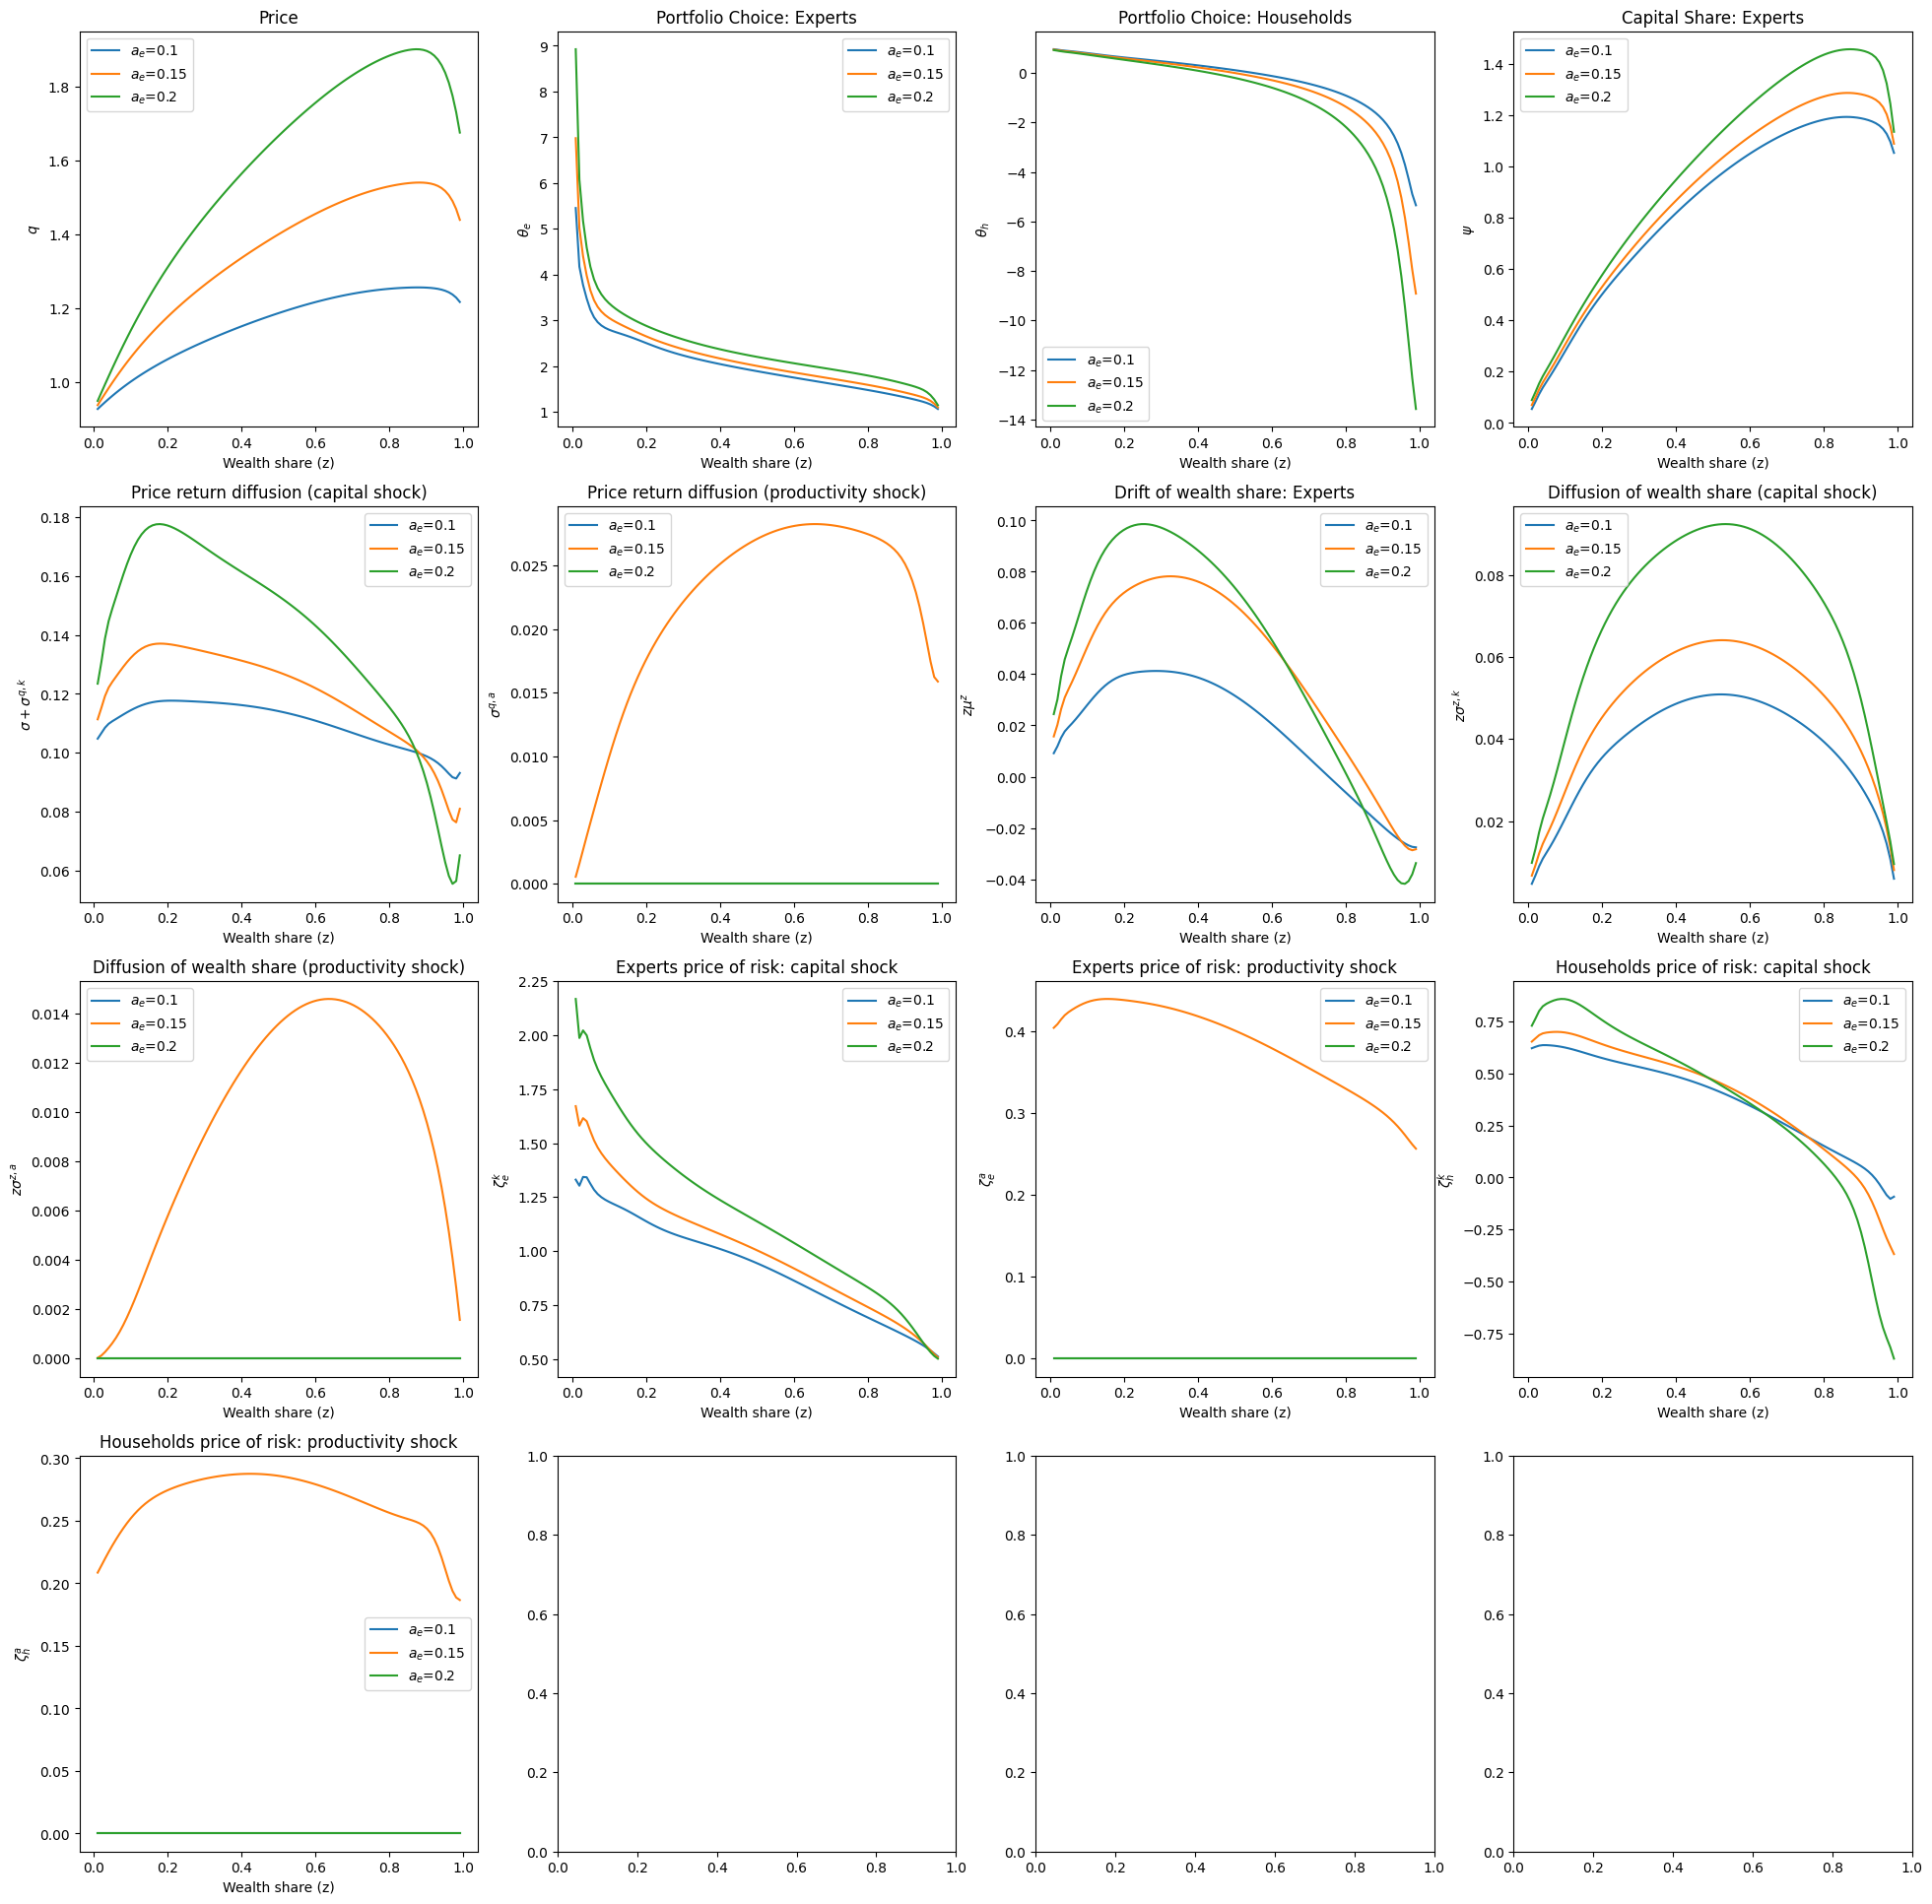

In [ ]:
set_seeds(0)
pde_model = PDEModelTimeStep("cd2d_ts",
                     {"batch_size": 20, "num_outer_iterations": 50, "num_inner_iterations": 5000},
                     latex_var_map)
pde_model.set_state(["z", "ae"], {"z": [z_min, z_max], "ae": [a_min, a_max]})
pde_model.add_agents(["Je", "Jh"],
                     {"Je": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "Jh": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                     })
pde_model.add_endogs(["q", "psi"],
                     {"q": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "psi": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      })
pde_model.add_params(params)
zero_z = torch.zeros((100, 3), device=pde_model.device)
zero_z[:, 1] = torch.linspace(a_min, a_max, steps=100, device=pde_model.device)
one_z = torch.zeros((100, 3), device=pde_model.device)
one_z[:, 0] = torch.ones((100,), device=pde_model.device)
one_z[:, 1] = torch.linspace(a_min, a_max, steps=100, device=pde_model.device)
pde_model.add_endog_condition("q",
                              "q(SV)",
                              {"SV": zero_z},
                              Comparator.EQ,
                              "(1+kappa*ah)/(1+kappa*rho)", {"rho": params["rho"], "ah": params["ah"], "kappa": params["kappa"]},
                              label="q_min", weight=0.01)
pde_model.add_endog_condition("q",
                              "q(SV)",
                              {"SV": one_z},
                              Comparator.EQ,
                              "(1+kappa*ae)/(1+kappa*rho)", {"rho": params["rho"], "ae": zero_z[:, 1:2], "kappa": params["kappa"]},
                              label="q_max", weight=0.01)
pde_model.add_endog_condition("psi",
                              "psi(SV)",
                              {"SV": zero_z},
                              Comparator.EQ,
                              "0", {},
                              label="psi_min", weight=0.01)
pde_model.add_endog_condition("psi",
                              "psi(SV)",
                              {"SV": one_z},
                              Comparator.EQ,
                              "1", {},
                              label="psi_max", weight=0.01)

pde_model.add_equation(r"$\iota &= \frac{q - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi &= \frac{\log ( q)}{\kappa}$")
pde_model.add_equation(r"$\hat{c}_e &= \rho$")
pde_model.add_equation(r"$\hat{c}_h &= \rho$")
pde_model.add_equation(r"$\mu_{ae} &= p * (\hat{a_e} - a_e)$")
pde_model.add_equation(r"$\sigma_{ae} &= v * (fu - a_e) * (a_e - fl)$")
pde_model.add_equation(r"$\theta_e &= \frac{\underline{\chi} * \psi}{z}$")
pde_model.add_equation(r"$\theta_h &= \frac{1 - \underline{\chi} * \psi}{1 - z}$")
pde_model.add_equation(r"$\sigma^{q,k} &= \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} * \psi - z)} - \sigma$")
pde_model.add_equation(r"$\sigma^{q,a} &= \frac{\frac{1}{q} * \frac{\partial q}{\partial a_e} * \sigma_{ae}}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} * \psi - z)}$")
pde_model.add_equation(r"$\sigma^{q,k,1} &= \sigma + \sigma^{q,k}$")
pde_model.add_equation(r"$\sigma^{z,k} &= \left(\theta_e - 1\right) * \sigma^{q,k,1}$")
pde_model.add_equation(r"$\sigma^{z,a} &= \left(\theta_e - 1\right) * \sigma^{q,a}$")
pde_model.add_equation(r"$\sigma_e^{J,k} &= \frac{1}{J_e} * \frac{\partial J_e}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_h^{J,k} &= \frac{1}{J_h} * \frac{\partial J_h}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_e^{J,a} &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial a_e} * \sigma_{ae} + \frac{\partial J_e}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\sigma_h^{J,a} &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial a_e} * \sigma_{ae} + \frac{\partial J_h}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\zeta_e^k &= -(1-\gamma) * \sigma_e^{J,k} + \sigma^{z,k} + \sigma^{q,k} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_e^a &= -(1-\gamma) * \sigma_e^{J,a} + \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_h^k &= -(1-\gamma) * \sigma_h^{J,k} - \frac{z}{1-z} * \sigma^{z,k} + \sigma^{q,k,1} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_h^a &= -(1-\gamma) * \sigma_h^{J,a} - \frac{z}{1-z} * \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_e^1 &= \zeta_e^k + \phi * \zeta_e^a$")
pde_model.add_equation(r"$\zeta_h^1 &= \zeta_h^k + \phi * \zeta_h^a$")
pde_model.add_equation(r"$\zeta_e^2 &= \zeta_e^a + \phi * \zeta_e^k$")
pde_model.add_equation(r"$\zeta_h^2 &= \zeta_h^a + \phi * \zeta_h^k$")
pde_model.add_equation(r"$\epsilon_e &= \sigma^{q,k,1} * \zeta_e^1 + \sigma^{q,a} * \zeta_e^2$")
pde_model.add_equation(r"$\epsilon_h &= \sigma^{q,k,1} * \zeta_h^1 + \sigma^{q,a} * \zeta_h^2$")
pde_model.add_equation(r"$\mu^z &= \frac{a_e - \iota}{q} - \hat{c}_e+ (\theta_e - 1) * (\sigma^{q,k,1} * (\zeta_e^1 - \sigma^{q,k,1}) + \sigma^{q,a} * (\zeta_e^2 - \sigma^{q,a}) - 2 * \phi * \sigma^{q,k,1} * \sigma^{q,a})+ (1-\underline{\chi}) * (\sigma^{q,k,1} * (\zeta_e^1 - \zeta_h^1) + \sigma^{q,a} * (\zeta_e^2 - \zeta_h^2)) + \frac{\lambda_d}{z} * (\bar{z} - z)$")
pde_model.add_equation(r"$\mu^q &= \frac{1}{q} * \left( \frac{\partial q}{\partial z} * \mu^z * z + \frac{\partial q}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2 q}{\partial z^2} * z^2 * ((\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k} * \sigma^{z,a})\right)+ \frac{1}{q} * \left( \frac{1}{2} * \frac{\partial^2 q}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 q}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a})  * \sigma_{ae} * z\right)$")
pde_model.add_equation(r"$\mu_e^J &= \frac{\gamma}{2} * ((\sigma_e^{J,k})^2 + (\sigma_e^{J,a})^2 + 2 * \phi * \sigma_e^{J,k} * \sigma_e^{J,a} + \sigma^2) - (\Phi - \delta) + (\gamma - 1) * ( \sigma_e^{J,k} * \sigma + \phi * \sigma * \sigma_e^{J,a}) - \rho * (\log(\rho) - \log(J_e) + \log(z*q))$")
pde_model.add_equation(r"$\mu_h^J &= \frac{\gamma}{2} * ((\sigma_h^{J,k})^2 + (\sigma_h^{J,a})^2 + 2*\phi*\sigma_h^{J,k} * \sigma_h^{J,a} + \sigma^2) - (\Phi-\delta) + (\gamma - 1) * (\sigma_h^{J,k}*\sigma + \phi*\sigma*\sigma_h^{J,a})- \rho * (\log(\rho) - \log(J_h) + \log((1-z)*q))$")
pde_model.add_equation(r"$\mu_e^R &= \frac{a_e - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$\mu_h^R &= \frac{a_h - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$r &= \mu_e^R - \underline{\chi} * \epsilon_e - (1-\underline{\chi}) * \epsilon_h$")
pde_model.add_equation(r"zmuz = z * muz")
pde_model.add_equation(r"zsigzk = z * sigzk")
pde_model.add_equation(r"zsigza = z * sigza")

pde_model.add_endog_equation(r"$\rho * q &= \psi * a_e + (1-\psi) * a_h - \iota$")
pde_model.add_endog_equation(r"$\frac{a_e - a_h}{q} &= \underline{\chi} * (\epsilon_e - \epsilon_h)$")

pde_model.add_hjb_equation(r"$\frac{\partial J_e}{\partial t} + \frac{\partial J_e}{\partial z} * \mu^z * z + \frac{\partial J_e}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_e}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) +\frac{1}{2} * \frac{\partial^2 J_e}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_e}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_e^J * J_e$")
pde_model.add_hjb_equation(r"$\frac{\partial J_h}{\partial t} + \frac{\partial J_h}{\partial z} * \mu^z * z + \frac{\partial J_h}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_h}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) + \frac{1}{2} * \frac{\partial^2 J_h}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_h}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_h^J * J_h$")

print(pde_model)
if not os.path.exists(f"{base_model_dir}/region1.pt"):
    pde_model.train_model(base_model_dir, "region1.pt", True)
    pde_model.load_model(torch.load(f"{base_model_dir}/region1_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{base_model_dir}/region1_best.pt"))
    pde_model.eval_model(True)

res_dict1 = compute_func(pde_model, a_list, z_min, z_max, vars_to_plot)
plot_res(res_dict1, plot_args, a_list)
torch.cuda.empty_cache()

## Region 2
$\psi = 1$, but $\epsilon_e \geq \epsilon_h$

============================Summary of Model cd2d_ts============================
Config: {
 "batch_size": 20,
 "num_outer_iterations": 50,
 "num_inner_iterations": 5000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001
}
Latex Variable Mapping:
{
 "J_e": "Je",
 "J_h": "Jh",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "Phi",
 "\\hat{c}_e": "ce",
 "\\hat{c}_h": "ch",
 "\\mu_{ae}": "muae",
 "\\sigma_{ae}": "sigae",
 "\\theta_e": "thetae",
 "\\theta_h": "thetah",
 "\\sigma^{q,k}": "sigqk",
 "\\sigma^{q,a}": "sigqa",
 "\\sigma^{q,k,1}": "sigsigqk",
 "\\sigma^{z,k}": "sigzk",
 "\\sigma^{z,a}": "sigza",
 "\\sigma_e^{J,k}": "sigJe_k",
 "\\sigma_h^{J,k}": "sigJh_k",
 "\\sigma_e^{J,a}": "sigJe_a",
 "\\sigma_h^{J,a}": "sigJh_a",
 "\\zeta_e^k": "zetae_k",
 "\\zeta_e^a": "zetae_a",
 "\\zeta_h^k": "zetah_k",
 "\\zeta_h^a": "zetah_a",
 "\\zeta_e^1": "zetae_1",
 "\\zeta_e^2": "zetae_2",
 "\\zeta_h^1": "zetah_1",

Total loss: 0.0012: 100%|██████████| 5000/5000 [14:17<00:00,  5.83it/s]


Model loaded
Je: Mean Value: 0.82812, Absolute Change: 0.17188, Relative Change:  0.17188
Jh: Mean Value: 0.82681, Absolute Change: 0.17319, Relative Change:  0.17319
q: Mean Value: 1.42955, Absolute Change: 0.42955, Relative Change:  0.42955
Updating min loss from inf to 0.0009
Outer Loop 0 Finished in 857.2712s. Loading best model...


Total loss: 0.0001: 100%|██████████| 3535/3535 [10:06<00:00,  5.83it/s]


Model loaded
Je: Mean Value: 0.69809, Absolute Change: 0.13003, Relative Change:  0.15842
Jh: Mean Value: 0.69509, Absolute Change: 0.13172, Relative Change:  0.16098
q: Mean Value: 1.39603, Absolute Change: 0.03352, Relative Change:  0.02359
Updating min loss from 0.0009 to 0.0001
Outer Loop 1 Finished in 606.4684s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2886/2886 [08:17<00:00,  5.80it/s]


Model loaded
Je: Mean Value: 0.59463, Absolute Change: 0.10346, Relative Change:  0.15034
Jh: Mean Value: 0.58998, Absolute Change: 0.10511, Relative Change:  0.15364
q: Mean Value: 1.39976, Absolute Change: 0.00746, Relative Change:  0.00560
Updating min loss from 0.0001 to 0.0001
Outer Loop 2 Finished in 497.7469s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2500/2500 [07:15<00:00,  5.74it/s]


Model loaded
Je: Mean Value: 0.51133, Absolute Change: 0.08330, Relative Change:  0.14270
Jh: Mean Value: 0.50520, Absolute Change: 0.08478, Relative Change:  0.14644
q: Mean Value: 1.39988, Absolute Change: 0.00439, Relative Change:  0.00314
Updating min loss from 0.0001 to 0.0001
Outer Loop 3 Finished in 435.6819s. Loading best model...


Total loss: 0.0002: 100%|██████████| 2236/2236 [06:22<00:00,  5.85it/s]


Model loaded
Je: Mean Value: 0.44338, Absolute Change: 0.06795, Relative Change:  0.13578
Jh: Mean Value: 0.43603, Absolute Change: 0.06917, Relative Change:  0.13987
q: Mean Value: 1.39904, Absolute Change: 0.00243, Relative Change:  0.00171
Updating min loss from 0.0001 to 0.0001
Outer Loop 4 Finished in 382.0246s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2041/2041 [05:54<00:00,  5.76it/s]


Model loaded
Je: Mean Value: 0.38734, Absolute Change: 0.05604, Relative Change:  0.12937
Jh: Mean Value: 0.37910, Absolute Change: 0.05693, Relative Change:  0.13366
q: Mean Value: 1.39900, Absolute Change: 0.00198, Relative Change:  0.00138
Updating min loss from 0.0001 to 0.0001
Outer Loop 5 Finished in 354.2776s. Loading best model...


Total loss: 0.0002: 100%|██████████| 1889/1889 [05:27<00:00,  5.76it/s]


Model loaded
Je: Mean Value: 0.34071, Absolute Change: 0.04663, Relative Change:  0.12337
Jh: Mean Value: 0.33180, Absolute Change: 0.04730, Relative Change:  0.12797
q: Mean Value: 1.39886, Absolute Change: 0.00113, Relative Change:  0.00079
Updating min loss from 0.0001 to 0.0001
Outer Loop 6 Finished in 327.9683s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1767/1767 [05:05<00:00,  5.78it/s]


Model loaded
Je: Mean Value: 0.30154, Absolute Change: 0.03917, Relative Change:  0.11790
Jh: Mean Value: 0.29229, Absolute Change: 0.03951, Relative Change:  0.12234
q: Mean Value: 1.39896, Absolute Change: 0.00056, Relative Change:  0.00039
Updating min loss from 0.0001 to 0.0001
Outer Loop 7 Finished in 305.5876s. Loading best model...


Total loss: 0.0001: 100%|██████████| 1666/1666 [04:50<00:00,  5.74it/s]


Model loaded
Je: Mean Value: 0.26890, Absolute Change: 0.03265, Relative Change:  0.11049
Jh: Mean Value: 0.25928, Absolute Change: 0.03302, Relative Change:  0.11623
q: Mean Value: 1.39874, Absolute Change: 0.00117, Relative Change:  0.00083
Updating min loss from 0.0001 to 0.0000
Outer Loop 8 Finished in 290.4442s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1581/1581 [04:28<00:00,  5.89it/s]


Model loaded
Je: Mean Value: 0.24570, Absolute Change: 0.02784, Relative Change:  0.10573
Jh: Mean Value: 0.23138, Absolute Change: 0.02789, Relative Change:  0.11086
q: Mean Value: 1.39971, Absolute Change: 0.01199, Relative Change:  0.00848
Updating min loss from 0.0000 to 0.0000
Outer Loop 9 Finished in 268.4157s. Loading best model...


Total loss: 0.0517: 100%|██████████| 1507/1507 [04:04<00:00,  6.16it/s]


Model loaded
Je: Mean Value: 0.20291, Absolute Change: 0.04280, Relative Change:  0.17344
Jh: Mean Value: 0.19684, Absolute Change: 0.03454, Relative Change:  0.15350
q: Mean Value: 1.38688, Absolute Change: 0.02866, Relative Change:  0.02055
Outer Loop 10 Finished in 244.5079s. Loading best model...


Total loss: 0.0749: 100%|██████████| 1443/1443 [03:54<00:00,  6.16it/s]


Model loaded
Je: Mean Value: 0.18735, Absolute Change: 0.01555, Relative Change:  0.07878
Jh: Mean Value: 0.19895, Absolute Change: 0.01768, Relative Change:  0.09673
q: Mean Value: 1.59404, Absolute Change: 0.20716, Relative Change:  0.15207
Outer Loop 11 Finished in 234.2079s. Loading best model...


Total loss: 0.0002: 100%|██████████| 1386/1386 [03:56<00:00,  5.86it/s]


Model loaded
Je: Mean Value: 0.17440, Absolute Change: 0.01605, Relative Change:  0.08892
Jh: Mean Value: 0.18092, Absolute Change: 0.01803, Relative Change:  0.09363
q: Mean Value: 1.38819, Absolute Change: 0.20586, Relative Change:  0.12907
Outer Loop 12 Finished in 236.6905s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1336/1336 [03:54<00:00,  5.71it/s]


Model loaded
Je: Mean Value: 0.16028, Absolute Change: 0.01412, Relative Change:  0.08238
Jh: Mean Value: 0.16504, Absolute Change: 0.01588, Relative Change:  0.09148
q: Mean Value: 1.38806, Absolute Change: 0.00531, Relative Change:  0.00387
Updating min loss from 0.0000 to 0.0000
Outer Loop 13 Finished in 234.0133s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1290/1290 [03:44<00:00,  5.76it/s]


Model loaded
Je: Mean Value: 0.14789, Absolute Change: 0.01239, Relative Change:  0.07864
Jh: Mean Value: 0.15095, Absolute Change: 0.01409, Relative Change:  0.08902
q: Mean Value: 1.39884, Absolute Change: 0.01086, Relative Change:  0.00792
Updating min loss from 0.0000 to 0.0000
Outer Loop 14 Finished in 224.0935s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1250/1250 [03:35<00:00,  5.81it/s]


Model loaded
Je: Mean Value: 0.13684, Absolute Change: 0.01106, Relative Change:  0.07621
Jh: Mean Value: 0.13846, Absolute Change: 0.01249, Relative Change:  0.08631
q: Mean Value: 1.39969, Absolute Change: 0.00184, Relative Change:  0.00134
Updating min loss from 0.0000 to 0.0000
Outer Loop 15 Finished in 215.3137s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1212/1212 [03:33<00:00,  5.67it/s]


Model loaded
Je: Mean Value: 0.12688, Absolute Change: 0.00995, Relative Change:  0.07427
Jh: Mean Value: 0.12783, Absolute Change: 0.01063, Relative Change:  0.07999
q: Mean Value: 1.39973, Absolute Change: 0.00079, Relative Change:  0.00057
Updating min loss from 0.0000 to 0.0000
Outer Loop 16 Finished in 213.6726s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1178/1178 [03:22<00:00,  5.83it/s]


Model loaded
Je: Mean Value: 0.11807, Absolute Change: 0.00881, Relative Change:  0.07102
Jh: Mean Value: 0.11803, Absolute Change: 0.00980, Relative Change:  0.07992
q: Mean Value: 1.39996, Absolute Change: 0.00080, Relative Change:  0.00058
Updating min loss from 0.0000 to 0.0000
Outer Loop 17 Finished in 202.1983s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1147/1147 [03:21<00:00,  5.69it/s]


Model loaded
Je: Mean Value: 0.11006, Absolute Change: 0.00801, Relative Change:  0.06952
Jh: Mean Value: 0.10910, Absolute Change: 0.00892, Relative Change:  0.07865
q: Mean Value: 1.39988, Absolute Change: 0.00090, Relative Change:  0.00062
Updating min loss from 0.0000 to 0.0000
Outer Loop 18 Finished in 201.6807s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1118/1118 [03:16<00:00,  5.70it/s]


Model loaded
Je: Mean Value: 0.10288, Absolute Change: 0.00719, Relative Change:  0.06694
Jh: Mean Value: 0.10134, Absolute Change: 0.00776, Relative Change:  0.07399
q: Mean Value: 1.39969, Absolute Change: 0.00100, Relative Change:  0.00073
Outer Loop 19 Finished in 196.2490s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1091/1091 [03:06<00:00,  5.84it/s]


Model loaded
Je: Mean Value: 0.09652, Absolute Change: 0.00636, Relative Change:  0.06336
Jh: Mean Value: 0.09442, Absolute Change: 0.00692, Relative Change:  0.07092
q: Mean Value: 1.39984, Absolute Change: 0.00151, Relative Change:  0.00108
Outer Loop 20 Finished in 186.7110s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1066/1066 [03:03<00:00,  5.82it/s]


Model loaded
Je: Mean Value: 0.09079, Absolute Change: 0.00573, Relative Change:  0.06084
Jh: Mean Value: 0.08822, Absolute Change: 0.00620, Relative Change:  0.06814
q: Mean Value: 1.40011, Absolute Change: 0.00086, Relative Change:  0.00062
Updating min loss from 0.0000 to 0.0000
Outer Loop 21 Finished in 183.0191s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1042/1042 [03:00<00:00,  5.76it/s]


Model loaded
Je: Mean Value: 0.08560, Absolute Change: 0.00520, Relative Change:  0.05874
Jh: Mean Value: 0.08264, Absolute Change: 0.00557, Relative Change:  0.06548
q: Mean Value: 1.40014, Absolute Change: 0.00077, Relative Change:  0.00054
Updating min loss from 0.0000 to 0.0000
Outer Loop 22 Finished in 180.9823s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1020/1020 [02:58<00:00,  5.70it/s]


Model loaded
Je: Mean Value: 0.08089, Absolute Change: 0.00470, Relative Change:  0.05633
Jh: Mean Value: 0.07763, Absolute Change: 0.00502, Relative Change:  0.06279
q: Mean Value: 1.40007, Absolute Change: 0.00061, Relative Change:  0.00044
Outer Loop 23 Finished in 178.9736s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1000/1000 [02:53<00:00,  5.77it/s]


Model loaded
Je: Mean Value: 0.07658, Absolute Change: 0.00432, Relative Change:  0.05486
Jh: Mean Value: 0.07310, Absolute Change: 0.00453, Relative Change:  0.06024
q: Mean Value: 1.40029, Absolute Change: 0.00104, Relative Change:  0.00073
Updating min loss from 0.0000 to 0.0000
Outer Loop 24 Finished in 173.4620s. Loading best model...


Total loss: 0.0000: 100%|██████████| 980/980 [02:46<00:00,  5.89it/s]


Model loaded
Je: Mean Value: 0.07259, Absolute Change: 0.00398, Relative Change:  0.05346
Jh: Mean Value: 0.06900, Absolute Change: 0.00410, Relative Change:  0.05789
q: Mean Value: 1.40012, Absolute Change: 0.00053, Relative Change:  0.00038
Updating min loss from 0.0000 to 0.0000
Outer Loop 25 Finished in 166.3932s. Loading best model...


Total loss: 0.0000: 100%|██████████| 962/962 [02:50<00:00,  5.66it/s]


Model loaded
Je: Mean Value: 0.06917, Absolute Change: 0.00343, Relative Change:  0.04825
Jh: Mean Value: 0.06529, Absolute Change: 0.00371, Relative Change:  0.05536
q: Mean Value: 1.40023, Absolute Change: 0.00047, Relative Change:  0.00034
Updating min loss from 0.0000 to 0.0000
Outer Loop 26 Finished in 170.0645s. Loading best model...


Total loss: 0.0000: 100%|██████████| 944/944 [02:45<00:00,  5.70it/s]


Model loaded
Je: Mean Value: 0.06613, Absolute Change: 0.00304, Relative Change:  0.04460
Jh: Mean Value: 0.06194, Absolute Change: 0.00335, Relative Change:  0.05271
q: Mean Value: 1.40015, Absolute Change: 0.00052, Relative Change:  0.00037
Outer Loop 27 Finished in 165.5415s. Loading best model...


Total loss: 0.0000: 100%|██████████| 928/928 [02:42<00:00,  5.70it/s]


Model loaded
Je: Mean Value: 0.06323, Absolute Change: 0.00290, Relative Change:  0.04470
Jh: Mean Value: 0.05890, Absolute Change: 0.00304, Relative Change:  0.05048
q: Mean Value: 1.40025, Absolute Change: 0.00039, Relative Change:  0.00027
Updating min loss from 0.0000 to 0.0000
Outer Loop 28 Finished in 162.8334s. Loading best model...


Total loss: 0.0000: 100%|██████████| 912/912 [02:37<00:00,  5.79it/s]


Model loaded
Je: Mean Value: 0.06045, Absolute Change: 0.00279, Relative Change:  0.04530
Jh: Mean Value: 0.05612, Absolute Change: 0.00278, Relative Change:  0.04844
q: Mean Value: 1.40011, Absolute Change: 0.00052, Relative Change:  0.00037
Updating min loss from 0.0000 to 0.0000
Outer Loop 29 Finished in 157.4185s. Loading best model...


Total loss: 0.0000: 100%|██████████| 898/898 [02:35<00:00,  5.77it/s]


Model loaded
Je: Mean Value: 0.05786, Absolute Change: 0.00259, Relative Change:  0.04407
Jh: Mean Value: 0.05358, Absolute Change: 0.00255, Relative Change:  0.04653
q: Mean Value: 1.40032, Absolute Change: 0.00038, Relative Change:  0.00028
Updating min loss from 0.0000 to 0.0000
Outer Loop 30 Finished in 155.7214s. Loading best model...


Total loss: 0.0000: 100%|██████████| 883/883 [02:34<00:00,  5.71it/s]


Model loaded
Je: Mean Value: 0.05551, Absolute Change: 0.00235, Relative Change:  0.04183
Jh: Mean Value: 0.05124, Absolute Change: 0.00234, Relative Change:  0.04459
q: Mean Value: 1.40023, Absolute Change: 0.00023, Relative Change:  0.00017
Updating min loss from 0.0000 to 0.0000
Outer Loop 31 Finished in 154.6966s. Loading best model...


Total loss: 0.0000: 100%|██████████| 870/870 [02:33<00:00,  5.67it/s]


Model loaded
Je: Mean Value: 0.05335, Absolute Change: 0.00216, Relative Change:  0.04011
Jh: Mean Value: 0.04911, Absolute Change: 0.00214, Relative Change:  0.04257
q: Mean Value: 1.40039, Absolute Change: 0.00025, Relative Change:  0.00018
Updating min loss from 0.0000 to 0.0000
Outer Loop 32 Finished in 153.4639s. Loading best model...


Total loss: 0.0000: 100%|██████████| 857/857 [02:30<00:00,  5.69it/s]


Model loaded
Je: Mean Value: 0.05140, Absolute Change: 0.00195, Relative Change:  0.03746
Jh: Mean Value: 0.04715, Absolute Change: 0.00196, Relative Change:  0.04069
q: Mean Value: 1.40019, Absolute Change: 0.00026, Relative Change:  0.00019
Updating min loss from 0.0000 to 0.0000
Outer Loop 33 Finished in 150.5826s. Loading best model...


Total loss: 0.0000: 100%|██████████| 845/845 [02:27<00:00,  5.72it/s]


Model loaded
Je: Mean Value: 0.04959, Absolute Change: 0.00180, Relative Change:  0.03602
Jh: Mean Value: 0.04535, Absolute Change: 0.00179, Relative Change:  0.03877
q: Mean Value: 1.40033, Absolute Change: 0.00025, Relative Change:  0.00018
Updating min loss from 0.0000 to 0.0000
Outer Loop 34 Finished in 147.6136s. Loading best model...


Total loss: 0.0000: 100%|██████████| 833/833 [02:25<00:00,  5.73it/s]


Model loaded
Je: Mean Value: 0.04794, Absolute Change: 0.00165, Relative Change:  0.03408
Jh: Mean Value: 0.04371, Absolute Change: 0.00165, Relative Change:  0.03694
q: Mean Value: 1.40023, Absolute Change: 0.00020, Relative Change:  0.00014
Updating min loss from 0.0000 to 0.0000
Outer Loop 35 Finished in 145.3490s. Loading best model...


Total loss: 0.0000: 100%|██████████| 821/821 [02:22<00:00,  5.77it/s]


Model loaded
Je: Mean Value: 0.04641, Absolute Change: 0.00153, Relative Change:  0.03268
Jh: Mean Value: 0.04219, Absolute Change: 0.00152, Relative Change:  0.03517
q: Mean Value: 1.40039, Absolute Change: 0.00026, Relative Change:  0.00019
Updating min loss from 0.0000 to 0.0000
Outer Loop 36 Finished in 142.2730s. Loading best model...


Total loss: 0.0000: 100%|██████████| 811/811 [02:21<00:00,  5.73it/s]


Model loaded
Je: Mean Value: 0.04502, Absolute Change: 0.00139, Relative Change:  0.03069
Jh: Mean Value: 0.04080, Absolute Change: 0.00139, Relative Change:  0.03349
q: Mean Value: 1.40027, Absolute Change: 0.00024, Relative Change:  0.00018
Updating min loss from 0.0000 to 0.0000
Outer Loop 37 Finished in 141.5319s. Loading best model...


Total loss: 0.0000: 100%|██████████| 800/800 [02:19<00:00,  5.75it/s]


Model loaded
Je: Mean Value: 0.04374, Absolute Change: 0.00128, Relative Change:  0.02908
Jh: Mean Value: 0.03951, Absolute Change: 0.00129, Relative Change:  0.03190
q: Mean Value: 1.40040, Absolute Change: 0.00020, Relative Change:  0.00014
Updating min loss from 0.0000 to 0.0000
Outer Loop 38 Finished in 139.1137s. Loading best model...


Total loss: 0.0000: 100%|██████████| 790/790 [02:17<00:00,  5.73it/s]


Model loaded
Je: Mean Value: 0.04253, Absolute Change: 0.00121, Relative Change:  0.02818
Jh: Mean Value: 0.03831, Absolute Change: 0.00120, Relative Change:  0.03060
q: Mean Value: 1.40019, Absolute Change: 0.00021, Relative Change:  0.00015
Updating min loss from 0.0000 to 0.0000
Outer Loop 39 Finished in 137.7638s. Loading best model...


Total loss: 0.0000: 100%|██████████| 780/780 [02:15<00:00,  5.74it/s]


Model loaded
Je: Mean Value: 0.04142, Absolute Change: 0.00112, Relative Change:  0.02674
Jh: Mean Value: 0.03721, Absolute Change: 0.00111, Relative Change:  0.02909
q: Mean Value: 1.40039, Absolute Change: 0.00022, Relative Change:  0.00016
Updating min loss from 0.0000 to 0.0000
Outer Loop 40 Finished in 135.9270s. Loading best model...


Total loss: 0.0000: 100%|██████████| 771/771 [02:14<00:00,  5.72it/s]


Model loaded
Je: Mean Value: 0.04037, Absolute Change: 0.00105, Relative Change:  0.02571
Jh: Mean Value: 0.03619, Absolute Change: 0.00102, Relative Change:  0.02767
q: Mean Value: 1.40022, Absolute Change: 0.00020, Relative Change:  0.00015
Updating min loss from 0.0000 to 0.0000
Outer Loop 41 Finished in 134.8719s. Loading best model...


Total loss: 0.0000: 100%|██████████| 762/762 [02:13<00:00,  5.73it/s]


Model loaded
Je: Mean Value: 0.03942, Absolute Change: 0.00095, Relative Change:  0.02398
Jh: Mean Value: 0.03524, Absolute Change: 0.00094, Relative Change:  0.02630
q: Mean Value: 1.40033, Absolute Change: 0.00020, Relative Change:  0.00014
Updating min loss from 0.0000 to 0.0000
Outer Loop 42 Finished in 133.0872s. Loading best model...


Total loss: 0.0000: 100%|██████████| 753/753 [02:11<00:00,  5.72it/s]


Model loaded
Je: Mean Value: 0.03850, Absolute Change: 0.00092, Relative Change:  0.02356
Jh: Mean Value: 0.03437, Absolute Change: 0.00087, Relative Change:  0.02498
q: Mean Value: 1.40017, Absolute Change: 0.00019, Relative Change:  0.00014
Updating min loss from 0.0000 to 0.0000
Outer Loop 43 Finished in 131.5643s. Loading best model...


Total loss: 0.0000: 100%|██████████| 745/745 [02:10<00:00,  5.73it/s]


Model loaded
Je: Mean Value: 0.03767, Absolute Change: 0.00083, Relative Change:  0.02182
Jh: Mean Value: 0.03356, Absolute Change: 0.00081, Relative Change:  0.02379
q: Mean Value: 1.40032, Absolute Change: 0.00025, Relative Change:  0.00018
Updating min loss from 0.0000 to 0.0000
Outer Loop 44 Finished in 130.0994s. Loading best model...


Total loss: 0.0000: 100%|██████████| 737/737 [02:09<00:00,  5.71it/s]


Model loaded
Je: Mean Value: 0.03687, Absolute Change: 0.00080, Relative Change:  0.02144
Jh: Mean Value: 0.03281, Absolute Change: 0.00075, Relative Change:  0.02258
q: Mean Value: 1.40017, Absolute Change: 0.00020, Relative Change:  0.00014
Updating min loss from 0.0000 to 0.0000
Outer Loop 45 Finished in 129.0867s. Loading best model...


Total loss: 0.0000: 100%|██████████| 729/729 [02:07<00:00,  5.72it/s]


Model loaded
Je: Mean Value: 0.03615, Absolute Change: 0.00072, Relative Change:  0.01981
Jh: Mean Value: 0.03210, Absolute Change: 0.00070, Relative Change:  0.02154
q: Mean Value: 1.40031, Absolute Change: 0.00020, Relative Change:  0.00014
Updating min loss from 0.0000 to 0.0000
Outer Loop 46 Finished in 127.4096s. Loading best model...


Total loss: 0.0000: 100%|██████████| 721/721 [02:06<00:00,  5.70it/s]


Model loaded
Je: Mean Value: 0.03544, Absolute Change: 0.00071, Relative Change:  0.01962
Jh: Mean Value: 0.03145, Absolute Change: 0.00065, Relative Change:  0.02045
q: Mean Value: 1.40013, Absolute Change: 0.00022, Relative Change:  0.00016
Updating min loss from 0.0000 to 0.0000
Outer Loop 47 Finished in 126.3944s. Loading best model...


Total loss: 0.0000: 100%|██████████| 714/714 [02:05<00:00,  5.70it/s]


Model loaded
Je: Mean Value: 0.03481, Absolute Change: 0.00064, Relative Change:  0.01808
Jh: Mean Value: 0.03084, Absolute Change: 0.00061, Relative Change:  0.01953
q: Mean Value: 1.40026, Absolute Change: 0.00020, Relative Change:  0.00014
Updating min loss from 0.0000 to 0.0000
Outer Loop 48 Finished in 125.1645s. Loading best model...


Total loss: 0.0000: 100%|██████████| 707/707 [02:03<00:00,  5.71it/s]


Model loaded
Je: Mean Value: 0.03419, Absolute Change: 0.00062, Relative Change:  0.01775
Jh: Mean Value: 0.03027, Absolute Change: 0.00057, Relative Change:  0.01855
q: Mean Value: 1.40011, Absolute Change: 0.00022, Relative Change:  0.00016
Updating min loss from 0.0000 to 0.0000
Outer Loop 49 Finished in 123.8578s. Loading best model...
training finished, total time :: 11029.461572408676
Best model saved to ./models/cd_2d_timestep//region2_best.pt if valid
Model saved to ./models/cd_2d_timestep//region2.pt


<ipython-input-7-f18d288e2c7f>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pde_model.load_model(torch.load(f"{base_model_dir}/region2_best.pt"))


Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
constraint_1: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
agent_Je_cond_time_boundary: 0.0000,
agent_Jh_cond_time_boundary: 0.0000,
endogvar_q_cond_time_boundary: 0.0000,
total_loss: 0.0000


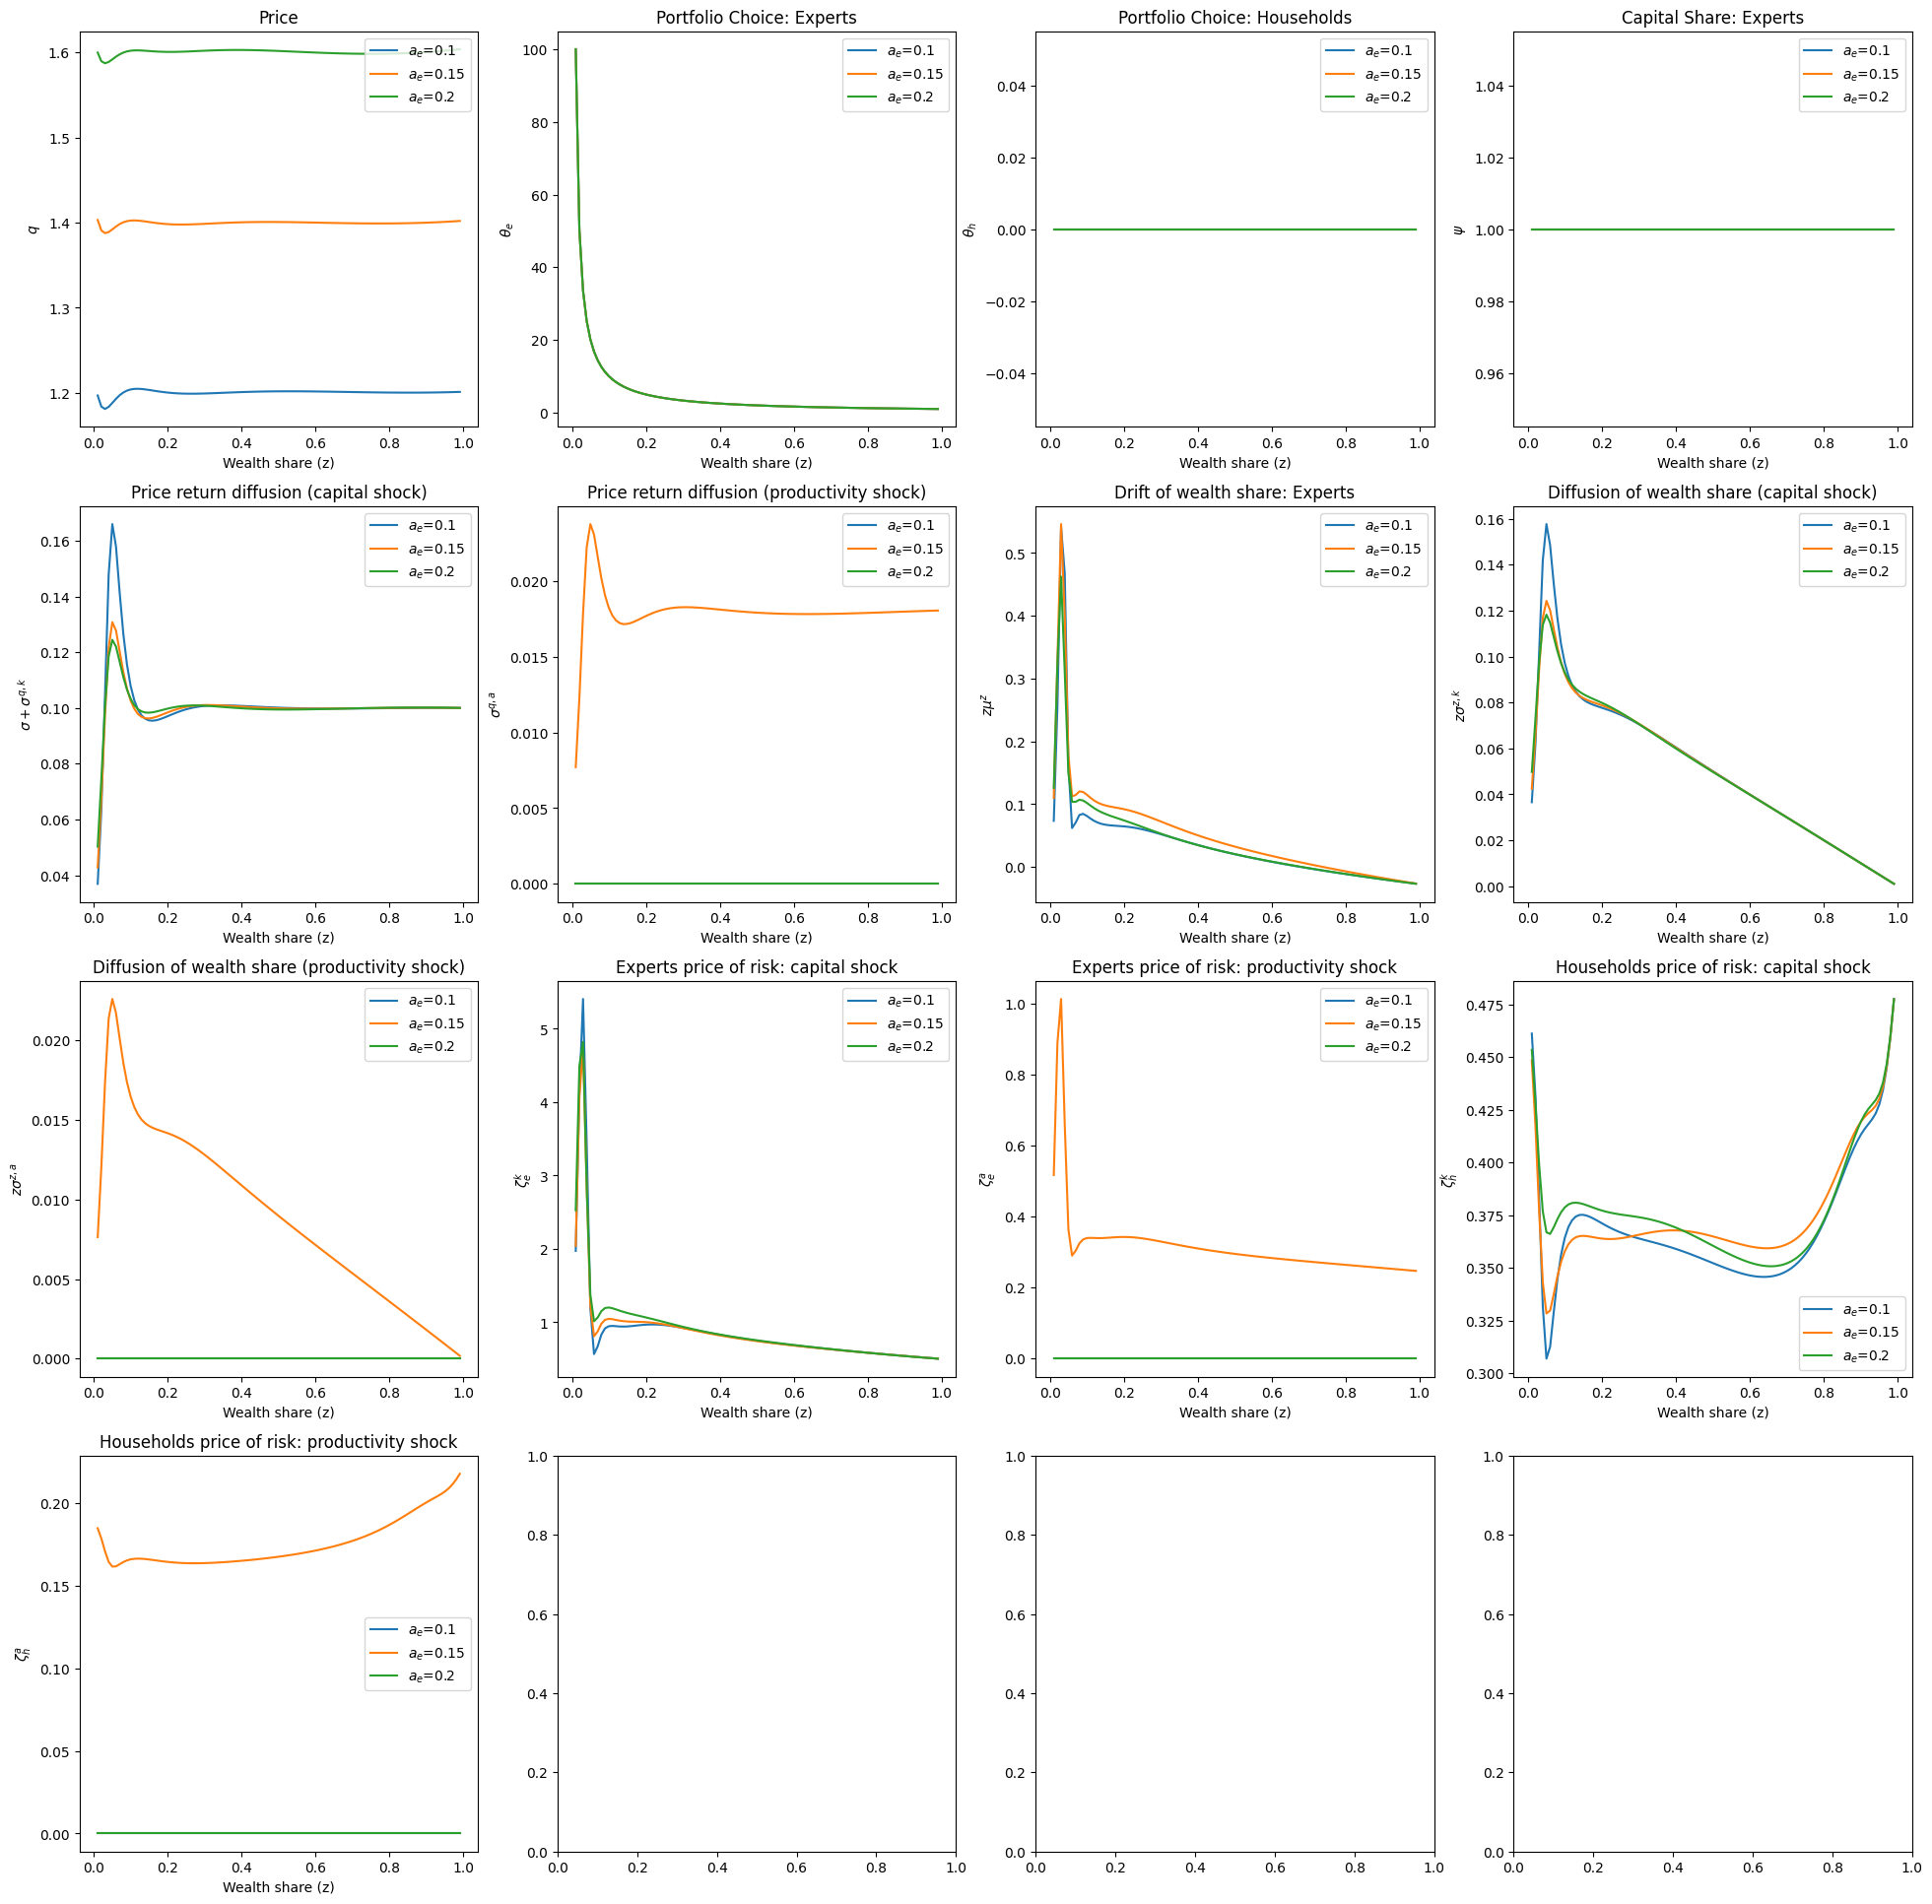

In [ ]:
set_seeds(0)
pde_model = PDEModelTimeStep("cd2d_ts",
                     {"batch_size": 20, "num_outer_iterations": 50, "num_inner_iterations": 5000},
                     latex_var_map)
torch.cuda.empty_cache()
pde_model.set_state(["z", "ae"], {"z": [z_min, z_max], "ae": [a_min, a_max]})
pde_model.add_agents(["Je", "Jh"],
                     {"Je": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "Jh": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                     })
pde_model.add_endogs(["q"],
                     {"q": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4}
                      })
pde_model.add_params(params)

pde_model.add_equation(r"$\iota &= \frac{q - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi &= \frac{\log ( q)}{\kappa}$")
pde_model.add_equation(r"$\hat{c}_e &= \rho$")
pde_model.add_equation(r"$\hat{c}_h &= \rho$")
pde_model.add_equation(r"$\mu_{ae} &= p * (\hat{a_e} - a_e)$")
pde_model.add_equation(r"$\sigma_{ae} &= v * (fu - a_e) * (a_e - fl)$")
pde_model.add_equation(r"$\theta_e &= \frac{\underline{\chi}}{z}$")
pde_model.add_equation(r"$\theta_h &= \frac{1 - \underline{\chi}}{1 - z}$")
pde_model.add_equation(r"$\sigma^{q,k} &= \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} - z)} - \sigma$")
pde_model.add_equation(r"$\sigma^{q,a} &= \frac{\frac{1}{q} * \frac{\partial q}{\partial a_e} * \sigma_{ae}}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} - z)}$")
pde_model.add_equation(r"$\sigma^{q,k,1} &= \sigma + \sigma^{q,k}$")
pde_model.add_equation(r"$\sigma^{z,k} &= \left(\theta_e - 1\right) * \sigma^{q,k,1}$")
pde_model.add_equation(r"$\sigma^{z,a} &= \left(\theta_e - 1\right) * \sigma^{q,a}$")
pde_model.add_equation(r"$\sigma_e^{J,k} &= \frac{1}{J_e} * \frac{\partial J_e}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_h^{J,k} &= \frac{1}{J_h} * \frac{\partial J_h}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_e^{J,a} &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial a_e} * \sigma_{ae} + \frac{\partial J_e}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\sigma_h^{J,a} &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial a_e} * \sigma_{ae} + \frac{\partial J_h}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\zeta_e^k &= -(1-\gamma) * \sigma_e^{J,k} + \sigma^{z,k} + \sigma^{q,k} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_e^a &= -(1-\gamma) * \sigma_e^{J,a} + \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_h^k &= -(1-\gamma) * \sigma_h^{J,k} - \frac{z}{1-z} * \sigma^{z,k} + \sigma^{q,k,1} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_h^a &= -(1-\gamma) * \sigma_h^{J,a} - \frac{z}{1-z} * \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_e^1 &= \zeta_e^k + \phi * \zeta_e^a$")
pde_model.add_equation(r"$\zeta_h^1 &= \zeta_h^k + \phi * \zeta_h^a$")
pde_model.add_equation(r"$\zeta_e^2 &= \zeta_e^a + \phi * \zeta_e^k$")
pde_model.add_equation(r"$\zeta_h^2 &= \zeta_h^a + \phi * \zeta_h^k$")
pde_model.add_equation(r"$\epsilon_e &= \sigma^{q,k,1} * \zeta_e^1 + \sigma^{q,a} * \zeta_e^2$")
pde_model.add_equation(r"$\epsilon_h &= \sigma^{q,k,1} * \zeta_h^1 + \sigma^{q,a} * \zeta_h^2$")
pde_model.add_equation(r"$\mu^z &= \frac{a_e - \iota}{q} - \hat{c}_e+ (\theta_e - 1) * (\sigma^{q,k,1} * (\zeta_e^1 - \sigma^{q,k,1}) + \sigma^{q,a} * (\zeta_e^2 - \sigma^{q,a}) - 2 * \phi * \sigma^{q,k,1} * \sigma^{q,a})+ (1-\underline{\chi}) * (\sigma^{q,k,1} * (\zeta_e^1 - \zeta_h^1) + \sigma^{q,a} * (\zeta_e^2 - \zeta_h^2)) + \frac{\lambda_d}{z} * (\bar{z} - z)$")
pde_model.add_equation(r"$\mu^q &= \frac{1}{q} * \left( \frac{\partial q}{\partial z} * \mu^z * z + \frac{\partial q}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2 q}{\partial z^2} * z^2 * ((\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k} * \sigma^{z,a})\right)+ \frac{1}{q} * \left( \frac{1}{2} * \frac{\partial^2 q}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 q}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a})  * \sigma_{ae} * z\right)$")
pde_model.add_equation(r"$\mu_e^J &= \frac{\gamma}{2} * ((\sigma_e^{J,k})^2 + (\sigma_e^{J,a})^2 + 2 * \phi * \sigma_e^{J,k} * \sigma_e^{J,a} + \sigma^2) - (\Phi - \delta) + (\gamma - 1) * ( \sigma_e^{J,k} * \sigma + \phi * \sigma * \sigma_e^{J,a}) - \rho * (\log(\rho) - \log(J_e) + \log(z*q))$")
pde_model.add_equation(r"$\mu_h^J &= \frac{\gamma}{2} * ((\sigma_h^{J,k})^2 + (\sigma_h^{J,a})^2 + 2*\phi*\sigma_h^{J,k} * \sigma_h^{J,a} + \sigma^2) - (\Phi-\delta) + (\gamma - 1) * (\sigma_h^{J,k}*\sigma + \phi*\sigma*\sigma_h^{J,a})- \rho * (\log(\rho) - \log(J_h) + \log((1-z)*q))$")
pde_model.add_equation(r"$\mu_e^R &= \frac{a_e - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$\mu_h^R &= \frac{a_h - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$r &= \mu_e^R - \underline{\chi} * \epsilon_e - (1-\underline{\chi}) * \epsilon_h$")
pde_model.add_equation(r"zmuz = z * muz")
pde_model.add_equation(r"zsigzk = z * sigzk")
pde_model.add_equation(r"zsigza = z * sigza")

pde_model.add_endog_equation(r"$\rho * q &= a_e - \iota$")
pde_model.add_constraint(r"$\frac{a_e - a_h}{q}$",
                         Comparator.GEQ,
                         r"$\underline{\chi} * (\epsilon_e - \epsilon_h)$")

pde_model.add_hjb_equation(r"$\frac{\partial J_e}{\partial t} + \frac{\partial J_e}{\partial z} * \mu^z * z + \frac{\partial J_e}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_e}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) +\frac{1}{2} * \frac{\partial^2 J_e}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_e}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_e^J * J_e$")
pde_model.add_hjb_equation(r"$\frac{\partial J_h}{\partial t} + \frac{\partial J_h}{\partial z} * \mu^z * z + \frac{\partial J_h}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_h}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) + \frac{1}{2} * \frac{\partial^2 J_h}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_h}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_h^J * J_h$")

print(pde_model)
if not os.path.exists(f"{base_model_dir}/region2.pt"):
    pde_model.train_model(base_model_dir, "region2.pt", True)
    pde_model.load_model(torch.load(f"{base_model_dir}/region2_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{base_model_dir}/region2_best.pt"))
    pde_model.eval_model(True)

res_dict2 = compute_func(pde_model, a_list, z_min, z_max, vars_to_plot)
plot_res(res_dict2, plot_args, a_list)
torch.cuda.empty_cache()

## Region 3
$\psi = 1$, but $\epsilon_e = \epsilon_h$

============================Summary of Model cd2d_ts============================
Config: {
 "batch_size": 20,
 "num_outer_iterations": 50,
 "num_inner_iterations": 5000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001
}
Latex Variable Mapping:
{
 "J_e": "Je",
 "J_h": "Jh",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "Phi",
 "\\hat{c}_e": "ce",
 "\\hat{c}_h": "ch",
 "\\mu_{ae}": "muae",
 "\\sigma_{ae}": "sigae",
 "\\theta_e": "thetae",
 "\\theta_h": "thetah",
 "\\sigma^{q,k}": "sigqk",
 "\\sigma^{q,a}": "sigqa",
 "\\sigma^{q,k,1}": "sigsigqk",
 "\\sigma^{z,k}": "sigzk",
 "\\sigma^{z,a}": "sigza",
 "\\sigma_e^{J,k}": "sigJe_k",
 "\\sigma_h^{J,k}": "sigJh_k",
 "\\sigma_e^{J,a}": "sigJe_a",
 "\\sigma_h^{J,a}": "sigJh_a",
 "\\zeta_e^k": "zetae_k",
 "\\zeta_e^a": "zetae_a",
 "\\zeta_h^k": "zetah_k",
 "\\zeta_h^a": "zetah_a",
 "\\zeta_e^1": "zetae_1",
 "\\zeta_e^2": "zetae_2",
 "\\zeta_h^1": "zetah_1",

Total loss: 0.0015: 100%|██████████| 5000/5000 [17:16<00:00,  4.82it/s]


Model loaded
Je: Mean Value: 0.82593, Absolute Change: 0.17407, Relative Change:  0.17407
Jh: Mean Value: 0.82800, Absolute Change: 0.17200, Relative Change:  0.17200
q: Mean Value: 1.41616, Absolute Change: 0.41616, Relative Change:  0.41616
chi: Mean Value: 0.60359, Absolute Change: 0.39641, Relative Change:  0.39641
Updating min loss from inf to 0.0010
Outer Loop 0 Finished in 1036.8912s. Loading best model...


Total loss: 0.0005: 100%|██████████| 3535/3535 [12:15<00:00,  4.81it/s]


Model loaded
Je: Mean Value: 0.69186, Absolute Change: 0.13407, Relative Change:  0.16457
Jh: Mean Value: 0.69821, Absolute Change: 0.12979, Relative Change:  0.15846
q: Mean Value: 1.39760, Absolute Change: 0.01857, Relative Change:  0.01354
chi: Mean Value: 0.59949, Absolute Change: 0.01328, Relative Change:  0.05326
Updating min loss from 0.0010 to 0.0000
Outer Loop 1 Finished in 735.3075s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2886/2886 [10:05<00:00,  4.77it/s]


Model loaded
Je: Mean Value: 0.58497, Absolute Change: 0.10689, Relative Change:  0.15851
Jh: Mean Value: 0.59541, Absolute Change: 0.10280, Relative Change:  0.14990
q: Mean Value: 1.39790, Absolute Change: 0.00334, Relative Change:  0.00237
chi: Mean Value: 0.59816, Absolute Change: 0.01736, Relative Change:  0.07315
Updating min loss from 0.0000 to 0.0000
Outer Loop 2 Finished in 605.5862s. Loading best model...


Total loss: 0.0001: 100%|██████████| 2500/2500 [08:40<00:00,  4.80it/s]


Model loaded
Je: Mean Value: 0.49908, Absolute Change: 0.08588, Relative Change:  0.15216
Jh: Mean Value: 0.51286, Absolute Change: 0.08255, Relative Change:  0.14193
q: Mean Value: 1.39849, Absolute Change: 0.00380, Relative Change:  0.00272
chi: Mean Value: 0.59004, Absolute Change: 0.01055, Relative Change:  0.02183
Updating min loss from 0.0000 to 0.0000
Outer Loop 3 Finished in 520.6267s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2236/2236 [07:47<00:00,  4.78it/s]


Model loaded
Je: Mean Value: 0.42914, Absolute Change: 0.06994, Relative Change:  0.14644
Jh: Mean Value: 0.44565, Absolute Change: 0.06721, Relative Change:  0.13477
q: Mean Value: 1.39930, Absolute Change: 0.00361, Relative Change:  0.00255
chi: Mean Value: 0.58441, Absolute Change: 0.00585, Relative Change:  0.01648
Updating min loss from 0.0000 to 0.0000
Outer Loop 4 Finished in 467.8192s. Loading best model...


Total loss: 0.0000: 100%|██████████| 2041/2041 [07:14<00:00,  4.70it/s]


Model loaded
Je: Mean Value: 0.37085, Absolute Change: 0.05830, Relative Change:  0.14279
Jh: Mean Value: 0.39030, Absolute Change: 0.05535, Relative Change:  0.12820
q: Mean Value: 1.39968, Absolute Change: 0.00103, Relative Change:  0.00074
chi: Mean Value: 0.57933, Absolute Change: 0.00508, Relative Change:  0.01218
Outer Loop 5 Finished in 434.1318s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1889/1889 [06:39<00:00,  4.73it/s]


Model loaded
Je: Mean Value: 0.32342, Absolute Change: 0.04743, Relative Change:  0.13533
Jh: Mean Value: 0.34444, Absolute Change: 0.04585, Relative Change:  0.12165
q: Mean Value: 1.39960, Absolute Change: 0.00122, Relative Change:  0.00088
chi: Mean Value: 0.57480, Absolute Change: 0.00454, Relative Change:  0.01045
Updating min loss from 0.0000 to 0.0000
Outer Loop 6 Finished in 399.4866s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1767/1767 [06:11<00:00,  4.76it/s]


Model loaded
Je: Mean Value: 0.28393, Absolute Change: 0.03949, Relative Change:  0.12985
Jh: Mean Value: 0.30605, Absolute Change: 0.03839, Relative Change:  0.11572
q: Mean Value: 1.39963, Absolute Change: 0.00099, Relative Change:  0.00071
chi: Mean Value: 0.57143, Absolute Change: 0.00337, Relative Change:  0.00790
Updating min loss from 0.0000 to 0.0000
Outer Loop 7 Finished in 371.0489s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1666/1666 [05:52<00:00,  4.72it/s]


Model loaded
Je: Mean Value: 0.25073, Absolute Change: 0.03320, Relative Change:  0.12483
Jh: Mean Value: 0.27368, Absolute Change: 0.03237, Relative Change:  0.11004
q: Mean Value: 1.39964, Absolute Change: 0.00045, Relative Change:  0.00032
chi: Mean Value: 0.56844, Absolute Change: 0.00300, Relative Change:  0.00697
Updating min loss from 0.0000 to 0.0000
Outer Loop 8 Finished in 352.9975s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1581/1581 [05:30<00:00,  4.79it/s]


Model loaded
Je: Mean Value: 0.22264, Absolute Change: 0.02809, Relative Change:  0.12001
Jh: Mean Value: 0.24616, Absolute Change: 0.02752, Relative Change:  0.10478
q: Mean Value: 1.39961, Absolute Change: 0.00014, Relative Change:  0.00010
chi: Mean Value: 0.56588, Absolute Change: 0.00256, Relative Change:  0.00600
Updating min loss from 0.0000 to 0.0000
Outer Loop 9 Finished in 330.2289s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1507/1507 [05:19<00:00,  4.71it/s]


Model loaded
Je: Mean Value: 0.19884, Absolute Change: 0.02380, Relative Change:  0.11478
Jh: Mean Value: 0.22260, Absolute Change: 0.02356, Relative Change:  0.09985
q: Mean Value: 1.39974, Absolute Change: 0.00029, Relative Change:  0.00021
chi: Mean Value: 0.56365, Absolute Change: 0.00223, Relative Change:  0.00542
Updating min loss from 0.0000 to 0.0000
Outer Loop 10 Finished in 319.9692s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1443/1443 [05:04<00:00,  4.73it/s]


Model loaded
Je: Mean Value: 0.17840, Absolute Change: 0.02044, Relative Change:  0.11060
Jh: Mean Value: 0.20234, Absolute Change: 0.02026, Relative Change:  0.09505
q: Mean Value: 1.39996, Absolute Change: 0.00025, Relative Change:  0.00018
chi: Mean Value: 0.56180, Absolute Change: 0.00186, Relative Change:  0.00449
Updating min loss from 0.0000 to 0.0000
Outer Loop 11 Finished in 304.8159s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1386/1386 [04:53<00:00,  4.72it/s]


Model loaded
Je: Mean Value: 0.16082, Absolute Change: 0.01757, Relative Change:  0.10616
Jh: Mean Value: 0.18481, Absolute Change: 0.01752, Relative Change:  0.09049
q: Mean Value: 1.39998, Absolute Change: 0.00006, Relative Change:  0.00005
chi: Mean Value: 0.56017, Absolute Change: 0.00164, Relative Change:  0.00396
Updating min loss from 0.0000 to 0.0000
Outer Loop 12 Finished in 293.7511s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1336/1336 [04:43<00:00,  4.71it/s]


Model loaded
Je: Mean Value: 0.14563, Absolute Change: 0.01520, Relative Change:  0.10194
Jh: Mean Value: 0.16956, Absolute Change: 0.01525, Relative Change:  0.08629
q: Mean Value: 1.39995, Absolute Change: 0.00013, Relative Change:  0.00009
chi: Mean Value: 0.55877, Absolute Change: 0.00141, Relative Change:  0.00336
Updating min loss from 0.0000 to 0.0000
Outer Loop 13 Finished in 283.7204s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1290/1290 [04:34<00:00,  4.70it/s]


Model loaded
Je: Mean Value: 0.13243, Absolute Change: 0.01320, Relative Change:  0.09785
Jh: Mean Value: 0.15621, Absolute Change: 0.01335, Relative Change:  0.08235
q: Mean Value: 1.39999, Absolute Change: 0.00013, Relative Change:  0.00010
chi: Mean Value: 0.55757, Absolute Change: 0.00120, Relative Change:  0.00286
Updating min loss from 0.0000 to 0.0000
Outer Loop 14 Finished in 274.5991s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1250/1250 [04:26<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.12092, Absolute Change: 0.01151, Relative Change:  0.09392
Jh: Mean Value: 0.14439, Absolute Change: 0.01182, Relative Change:  0.07923
q: Mean Value: 1.40004, Absolute Change: 0.00009, Relative Change:  0.00007
chi: Mean Value: 0.55660, Absolute Change: 0.00097, Relative Change:  0.00229
Outer Loop 15 Finished in 266.5643s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1212/1212 [04:16<00:00,  4.72it/s]


Model loaded
Je: Mean Value: 0.11084, Absolute Change: 0.01007, Relative Change:  0.09002
Jh: Mean Value: 0.13408, Absolute Change: 0.01031, Relative Change:  0.07467
q: Mean Value: 1.40012, Absolute Change: 0.00012, Relative Change:  0.00009
chi: Mean Value: 0.55570, Absolute Change: 0.00090, Relative Change:  0.00207
Updating min loss from 0.0000 to 0.0000
Outer Loop 16 Finished in 256.7444s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1178/1178 [04:10<00:00,  4.70it/s]


Model loaded
Je: Mean Value: 0.10198, Absolute Change: 0.00886, Relative Change:  0.08635
Jh: Mean Value: 0.12497, Absolute Change: 0.00911, Relative Change:  0.07106
q: Mean Value: 1.40007, Absolute Change: 0.00014, Relative Change:  0.00010
chi: Mean Value: 0.55496, Absolute Change: 0.00074, Relative Change:  0.00178
Updating min loss from 0.0000 to 0.0000
Outer Loop 17 Finished in 250.9020s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1147/1147 [04:06<00:00,  4.65it/s]


Model loaded
Je: Mean Value: 0.09416, Absolute Change: 0.00782, Relative Change:  0.08286
Jh: Mean Value: 0.11686, Absolute Change: 0.00811, Relative Change:  0.06785
q: Mean Value: 1.40014, Absolute Change: 0.00012, Relative Change:  0.00009
chi: Mean Value: 0.55427, Absolute Change: 0.00069, Relative Change:  0.00168
Updating min loss from 0.0000 to 0.0000
Outer Loop 18 Finished in 246.5792s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1118/1118 [03:58<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.08724, Absolute Change: 0.00692, Relative Change:  0.07947
Jh: Mean Value: 0.10962, Absolute Change: 0.00724, Relative Change:  0.06469
q: Mean Value: 1.40017, Absolute Change: 0.00008, Relative Change:  0.00006
chi: Mean Value: 0.55368, Absolute Change: 0.00060, Relative Change:  0.00146
Updating min loss from 0.0000 to 0.0000
Outer Loop 19 Finished in 238.1487s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1091/1091 [03:53<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.08109, Absolute Change: 0.00615, Relative Change:  0.07620
Jh: Mean Value: 0.10315, Absolute Change: 0.00647, Relative Change:  0.06168
q: Mean Value: 1.40019, Absolute Change: 0.00009, Relative Change:  0.00007
chi: Mean Value: 0.55312, Absolute Change: 0.00056, Relative Change:  0.00141
Updating min loss from 0.0000 to 0.0000
Outer Loop 20 Finished in 233.8259s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1066/1066 [03:47<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.07560, Absolute Change: 0.00549, Relative Change:  0.07313
Jh: Mean Value: 0.09734, Absolute Change: 0.00581, Relative Change:  0.05881
q: Mean Value: 1.40023, Absolute Change: 0.00011, Relative Change:  0.00008
chi: Mean Value: 0.55261, Absolute Change: 0.00051, Relative Change:  0.00130
Updating min loss from 0.0000 to 0.0000
Outer Loop 21 Finished in 227.3150s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1042/1042 [03:42<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.07069, Absolute Change: 0.00491, Relative Change:  0.07014
Jh: Mean Value: 0.09210, Absolute Change: 0.00523, Relative Change:  0.05607
q: Mean Value: 1.40025, Absolute Change: 0.00008, Relative Change:  0.00005
chi: Mean Value: 0.55215, Absolute Change: 0.00046, Relative Change:  0.00119
Updating min loss from 0.0000 to 0.0000
Outer Loop 22 Finished in 222.5865s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1020/1020 [03:37<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.06629, Absolute Change: 0.00440, Relative Change:  0.06709
Jh: Mean Value: 0.08738, Absolute Change: 0.00473, Relative Change:  0.05348
q: Mean Value: 1.40014, Absolute Change: 0.00012, Relative Change:  0.00009
chi: Mean Value: 0.55173, Absolute Change: 0.00042, Relative Change:  0.00107
Updating min loss from 0.0000 to 0.0000
Outer Loop 23 Finished in 217.6993s. Loading best model...


Total loss: 0.0000: 100%|██████████| 1000/1000 [03:34<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.06234, Absolute Change: 0.00395, Relative Change:  0.06425
Jh: Mean Value: 0.08310, Absolute Change: 0.00428, Relative Change:  0.05100
q: Mean Value: 1.40015, Absolute Change: 0.00007, Relative Change:  0.00005
chi: Mean Value: 0.55132, Absolute Change: 0.00041, Relative Change:  0.00101
Updating min loss from 0.0000 to 0.0000
Outer Loop 24 Finished in 214.3133s. Loading best model...


Total loss: 0.0000: 100%|██████████| 980/980 [03:30<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.05876, Absolute Change: 0.00357, Relative Change:  0.06166
Jh: Mean Value: 0.07922, Absolute Change: 0.00388, Relative Change:  0.04864
q: Mean Value: 1.40026, Absolute Change: 0.00011, Relative Change:  0.00008
chi: Mean Value: 0.55096, Absolute Change: 0.00037, Relative Change:  0.00089
Updating min loss from 0.0000 to 0.0000
Outer Loop 25 Finished in 210.2968s. Loading best model...


Total loss: 0.0000: 100%|██████████| 962/962 [03:25<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.05554, Absolute Change: 0.00322, Relative Change:  0.05895
Jh: Mean Value: 0.07569, Absolute Change: 0.00353, Relative Change:  0.04638
q: Mean Value: 1.40031, Absolute Change: 0.00008, Relative Change:  0.00006
chi: Mean Value: 0.55064, Absolute Change: 0.00033, Relative Change:  0.00083
Updating min loss from 0.0000 to 0.0000
Outer Loop 26 Finished in 205.9105s. Loading best model...


Total loss: 0.0000: 100%|██████████| 944/944 [03:22<00:00,  4.65it/s]


Model loaded
Je: Mean Value: 0.05262, Absolute Change: 0.00292, Relative Change:  0.05641
Jh: Mean Value: 0.07247, Absolute Change: 0.00322, Relative Change:  0.04423
q: Mean Value: 1.40035, Absolute Change: 0.00008, Relative Change:  0.00006
chi: Mean Value: 0.55034, Absolute Change: 0.00030, Relative Change:  0.00074
Updating min loss from 0.0000 to 0.0000
Outer Loop 27 Finished in 202.9976s. Loading best model...


Total loss: 0.0000: 100%|██████████| 928/928 [03:18<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.04997, Absolute Change: 0.00265, Relative Change:  0.05398
Jh: Mean Value: 0.06952, Absolute Change: 0.00294, Relative Change:  0.04216
q: Mean Value: 1.40037, Absolute Change: 0.00004, Relative Change:  0.00003
chi: Mean Value: 0.55008, Absolute Change: 0.00026, Relative Change:  0.00066
Updating min loss from 0.0000 to 0.0000
Outer Loop 28 Finished in 198.7984s. Loading best model...


Total loss: 0.0000: 100%|██████████| 912/912 [03:15<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.04756, Absolute Change: 0.00241, Relative Change:  0.05162
Jh: Mean Value: 0.06683, Absolute Change: 0.00269, Relative Change:  0.04019
q: Mean Value: 1.40042, Absolute Change: 0.00008, Relative Change:  0.00006
chi: Mean Value: 0.54983, Absolute Change: 0.00025, Relative Change:  0.00063
Updating min loss from 0.0000 to 0.0000
Outer Loop 29 Finished in 195.5279s. Loading best model...


Total loss: 0.0000: 100%|██████████| 898/898 [03:13<00:00,  4.65it/s]


Model loaded
Je: Mean Value: 0.04537, Absolute Change: 0.00220, Relative Change:  0.04937
Jh: Mean Value: 0.06436, Absolute Change: 0.00247, Relative Change:  0.03832
q: Mean Value: 1.40044, Absolute Change: 0.00008, Relative Change:  0.00006
chi: Mean Value: 0.54963, Absolute Change: 0.00021, Relative Change:  0.00055
Outer Loop 30 Finished in 193.0633s. Loading best model...


Total loss: 0.0000: 100%|██████████| 883/883 [03:09<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.04336, Absolute Change: 0.00201, Relative Change:  0.04720
Jh: Mean Value: 0.06209, Absolute Change: 0.00227, Relative Change:  0.03651
q: Mean Value: 1.40042, Absolute Change: 0.00008, Relative Change:  0.00006
chi: Mean Value: 0.54942, Absolute Change: 0.00021, Relative Change:  0.00054
Updating min loss from 0.0000 to 0.0000
Outer Loop 31 Finished in 189.5122s. Loading best model...


Total loss: 0.0000: 100%|██████████| 870/870 [03:07<00:00,  4.65it/s]


Model loaded
Je: Mean Value: 0.04152, Absolute Change: 0.00184, Relative Change:  0.04513
Jh: Mean Value: 0.06001, Absolute Change: 0.00209, Relative Change:  0.03480
q: Mean Value: 1.40029, Absolute Change: 0.00013, Relative Change:  0.00009
chi: Mean Value: 0.54925, Absolute Change: 0.00018, Relative Change:  0.00048
Outer Loop 32 Finished in 187.1019s. Loading best model...


Total loss: 0.0000: 100%|██████████| 857/857 [03:04<00:00,  4.65it/s]


Model loaded
Je: Mean Value: 0.03984, Absolute Change: 0.00168, Relative Change:  0.04314
Jh: Mean Value: 0.05808, Absolute Change: 0.00192, Relative Change:  0.03316
q: Mean Value: 1.40029, Absolute Change: 0.00006, Relative Change:  0.00005
chi: Mean Value: 0.54908, Absolute Change: 0.00018, Relative Change:  0.00047
Outer Loop 33 Finished in 184.3349s. Loading best model...


Total loss: 0.0000: 100%|██████████| 845/845 [03:00<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.03829, Absolute Change: 0.00155, Relative Change:  0.04123
Jh: Mean Value: 0.05631, Absolute Change: 0.00178, Relative Change:  0.03160
q: Mean Value: 1.40025, Absolute Change: 0.00017, Relative Change:  0.00012
chi: Mean Value: 0.54893, Absolute Change: 0.00015, Relative Change:  0.00042
Updating min loss from 0.0000 to 0.0000
Outer Loop 34 Finished in 180.9775s. Loading best model...


Total loss: 0.0000: 100%|██████████| 833/833 [02:58<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.03687, Absolute Change: 0.00142, Relative Change:  0.03939
Jh: Mean Value: 0.05467, Absolute Change: 0.00164, Relative Change:  0.03010
q: Mean Value: 1.40018, Absolute Change: 0.00011, Relative Change:  0.00008
chi: Mean Value: 0.54878, Absolute Change: 0.00016, Relative Change:  0.00045
Updating min loss from 0.0000 to 0.0000
Outer Loop 35 Finished in 178.2994s. Loading best model...


Total loss: 0.0000: 100%|██████████| 821/821 [02:55<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.03556, Absolute Change: 0.00131, Relative Change:  0.03767
Jh: Mean Value: 0.05315, Absolute Change: 0.00152, Relative Change:  0.02864
q: Mean Value: 1.40018, Absolute Change: 0.00004, Relative Change:  0.00003
chi: Mean Value: 0.54862, Absolute Change: 0.00015, Relative Change:  0.00041
Updating min loss from 0.0000 to 0.0000
Outer Loop 36 Finished in 175.6967s. Loading best model...


Total loss: 0.0000: 100%|██████████| 811/811 [02:53<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.03435, Absolute Change: 0.00121, Relative Change:  0.03599
Jh: Mean Value: 0.05174, Absolute Change: 0.00141, Relative Change:  0.02727
q: Mean Value: 1.40020, Absolute Change: 0.00008, Relative Change:  0.00006
chi: Mean Value: 0.54851, Absolute Change: 0.00012, Relative Change:  0.00035
Updating min loss from 0.0000 to 0.0000
Outer Loop 37 Finished in 173.4710s. Loading best model...


Total loss: 0.0000: 100%|██████████| 800/800 [02:51<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.03323, Absolute Change: 0.00112, Relative Change:  0.03437
Jh: Mean Value: 0.05044, Absolute Change: 0.00130, Relative Change:  0.02595
q: Mean Value: 1.40013, Absolute Change: 0.00011, Relative Change:  0.00008
chi: Mean Value: 0.54839, Absolute Change: 0.00013, Relative Change:  0.00037
Updating min loss from 0.0000 to 0.0000
Outer Loop 38 Finished in 171.0405s. Loading best model...


Total loss: 0.0000: 100%|██████████| 790/790 [02:48<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.03220, Absolute Change: 0.00103, Relative Change:  0.03283
Jh: Mean Value: 0.04923, Absolute Change: 0.00121, Relative Change:  0.02470
q: Mean Value: 1.40017, Absolute Change: 0.00011, Relative Change:  0.00008
chi: Mean Value: 0.54829, Absolute Change: 0.00010, Relative Change:  0.00033
Updating min loss from 0.0000 to 0.0000
Outer Loop 39 Finished in 168.8342s. Loading best model...


Total loss: 0.0000: 100%|██████████| 780/780 [02:46<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.03124, Absolute Change: 0.00096, Relative Change:  0.03131
Jh: Mean Value: 0.04810, Absolute Change: 0.00113, Relative Change:  0.02347
q: Mean Value: 1.40032, Absolute Change: 0.00015, Relative Change:  0.00011
chi: Mean Value: 0.54818, Absolute Change: 0.00012, Relative Change:  0.00038
Updating min loss from 0.0000 to 0.0000
Outer Loop 40 Finished in 166.7963s. Loading best model...


Total loss: 0.0000: 100%|██████████| 771/771 [02:44<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.03035, Absolute Change: 0.00089, Relative Change:  0.02992
Jh: Mean Value: 0.04706, Absolute Change: 0.00105, Relative Change:  0.02235
q: Mean Value: 1.40033, Absolute Change: 0.00006, Relative Change:  0.00004
chi: Mean Value: 0.54810, Absolute Change: 0.00009, Relative Change:  0.00033
Outer Loop 41 Finished in 164.5977s. Loading best model...


Total loss: 0.0000: 100%|██████████| 762/762 [02:40<00:00,  4.74it/s]


Model loaded
Je: Mean Value: 0.02953, Absolute Change: 0.00082, Relative Change:  0.02837
Jh: Mean Value: 0.04608, Absolute Change: 0.00098, Relative Change:  0.02124
q: Mean Value: 1.40026, Absolute Change: 0.00010, Relative Change:  0.00007
chi: Mean Value: 0.54802, Absolute Change: 0.00011, Relative Change:  0.00043
Updating min loss from 0.0000 to 0.0000
Outer Loop 42 Finished in 160.9016s. Loading best model...


Total loss: 0.0000: 100%|██████████| 753/753 [02:40<00:00,  4.69it/s]


Model loaded
Je: Mean Value: 0.02876, Absolute Change: 0.00077, Relative Change:  0.02717
Jh: Mean Value: 0.04517, Absolute Change: 0.00091, Relative Change:  0.02018
q: Mean Value: 1.40025, Absolute Change: 0.00007, Relative Change:  0.00005
chi: Mean Value: 0.54793, Absolute Change: 0.00010, Relative Change:  0.00034
Outer Loop 43 Finished in 160.5457s. Loading best model...


Total loss: 0.0000: 100%|██████████| 745/745 [02:39<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.02805, Absolute Change: 0.00071, Relative Change:  0.02597
Jh: Mean Value: 0.04432, Absolute Change: 0.00085, Relative Change:  0.01915
q: Mean Value: 1.40022, Absolute Change: 0.00006, Relative Change:  0.00004
chi: Mean Value: 0.54781, Absolute Change: 0.00013, Relative Change:  0.00041
Updating min loss from 0.0000 to 0.0000
Outer Loop 44 Finished in 159.9209s. Loading best model...


Total loss: 0.0000: 100%|██████████| 737/737 [02:37<00:00,  4.67it/s]


Model loaded
Je: Mean Value: 0.02738, Absolute Change: 0.00067, Relative Change:  0.02484
Jh: Mean Value: 0.04353, Absolute Change: 0.00079, Relative Change:  0.01822
q: Mean Value: 1.40028, Absolute Change: 0.00013, Relative Change:  0.00010
chi: Mean Value: 0.54772, Absolute Change: 0.00011, Relative Change:  0.00039
Outer Loop 45 Finished in 157.8599s. Loading best model...


Total loss: 0.0000: 100%|██████████| 729/729 [02:36<00:00,  4.66it/s]


Model loaded
Je: Mean Value: 0.02676, Absolute Change: 0.00062, Relative Change:  0.02366
Jh: Mean Value: 0.04279, Absolute Change: 0.00074, Relative Change:  0.01733
q: Mean Value: 1.40032, Absolute Change: 0.00009, Relative Change:  0.00006
chi: Mean Value: 0.54763, Absolute Change: 0.00011, Relative Change:  0.00042
Outer Loop 46 Finished in 156.3097s. Loading best model...


Total loss: 0.0000: 100%|██████████| 721/721 [02:33<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.02618, Absolute Change: 0.00058, Relative Change:  0.02261
Jh: Mean Value: 0.04210, Absolute Change: 0.00069, Relative Change:  0.01650
q: Mean Value: 1.40030, Absolute Change: 0.00007, Relative Change:  0.00005
chi: Mean Value: 0.54758, Absolute Change: 0.00007, Relative Change:  0.00032
Outer Loop 47 Finished in 153.9176s. Loading best model...


Total loss: 0.0000: 100%|██████████| 714/714 [02:32<00:00,  4.68it/s]


Model loaded
Je: Mean Value: 0.02564, Absolute Change: 0.00054, Relative Change:  0.02154
Jh: Mean Value: 0.04145, Absolute Change: 0.00065, Relative Change:  0.01567
q: Mean Value: 1.40024, Absolute Change: 0.00010, Relative Change:  0.00007
chi: Mean Value: 0.54745, Absolute Change: 0.00014, Relative Change:  0.00045
Outer Loop 48 Finished in 152.6304s. Loading best model...


Total loss: 0.0000: 100%|██████████| 707/707 [02:32<00:00,  4.64it/s]


Model loaded
Je: Mean Value: 0.02513, Absolute Change: 0.00051, Relative Change:  0.02070
Jh: Mean Value: 0.04084, Absolute Change: 0.00061, Relative Change:  0.01495
q: Mean Value: 1.40021, Absolute Change: 0.00013, Relative Change:  0.00009
chi: Mean Value: 0.54741, Absolute Change: 0.00006, Relative Change:  0.00029
Outer Loop 49 Finished in 152.2753s. Loading best model...
training finished, total time :: 13519.106888532639
Best model saved to ./models/cd_2d_timestep//region3_best.pt if valid
Model saved to ./models/cd_2d_timestep//region3.pt


<ipython-input-8-23c93b356637>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pde_model.load_model(torch.load(f"{base_model_dir}/region3_best.pt"))


Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
agent_Je_cond_time_boundary: 0.0000,
agent_Jh_cond_time_boundary: 0.0000,
endogvar_q_cond_time_boundary: 0.0000,
endogvar_chi_cond_time_boundary: 0.0000,
total_loss: 0.0000


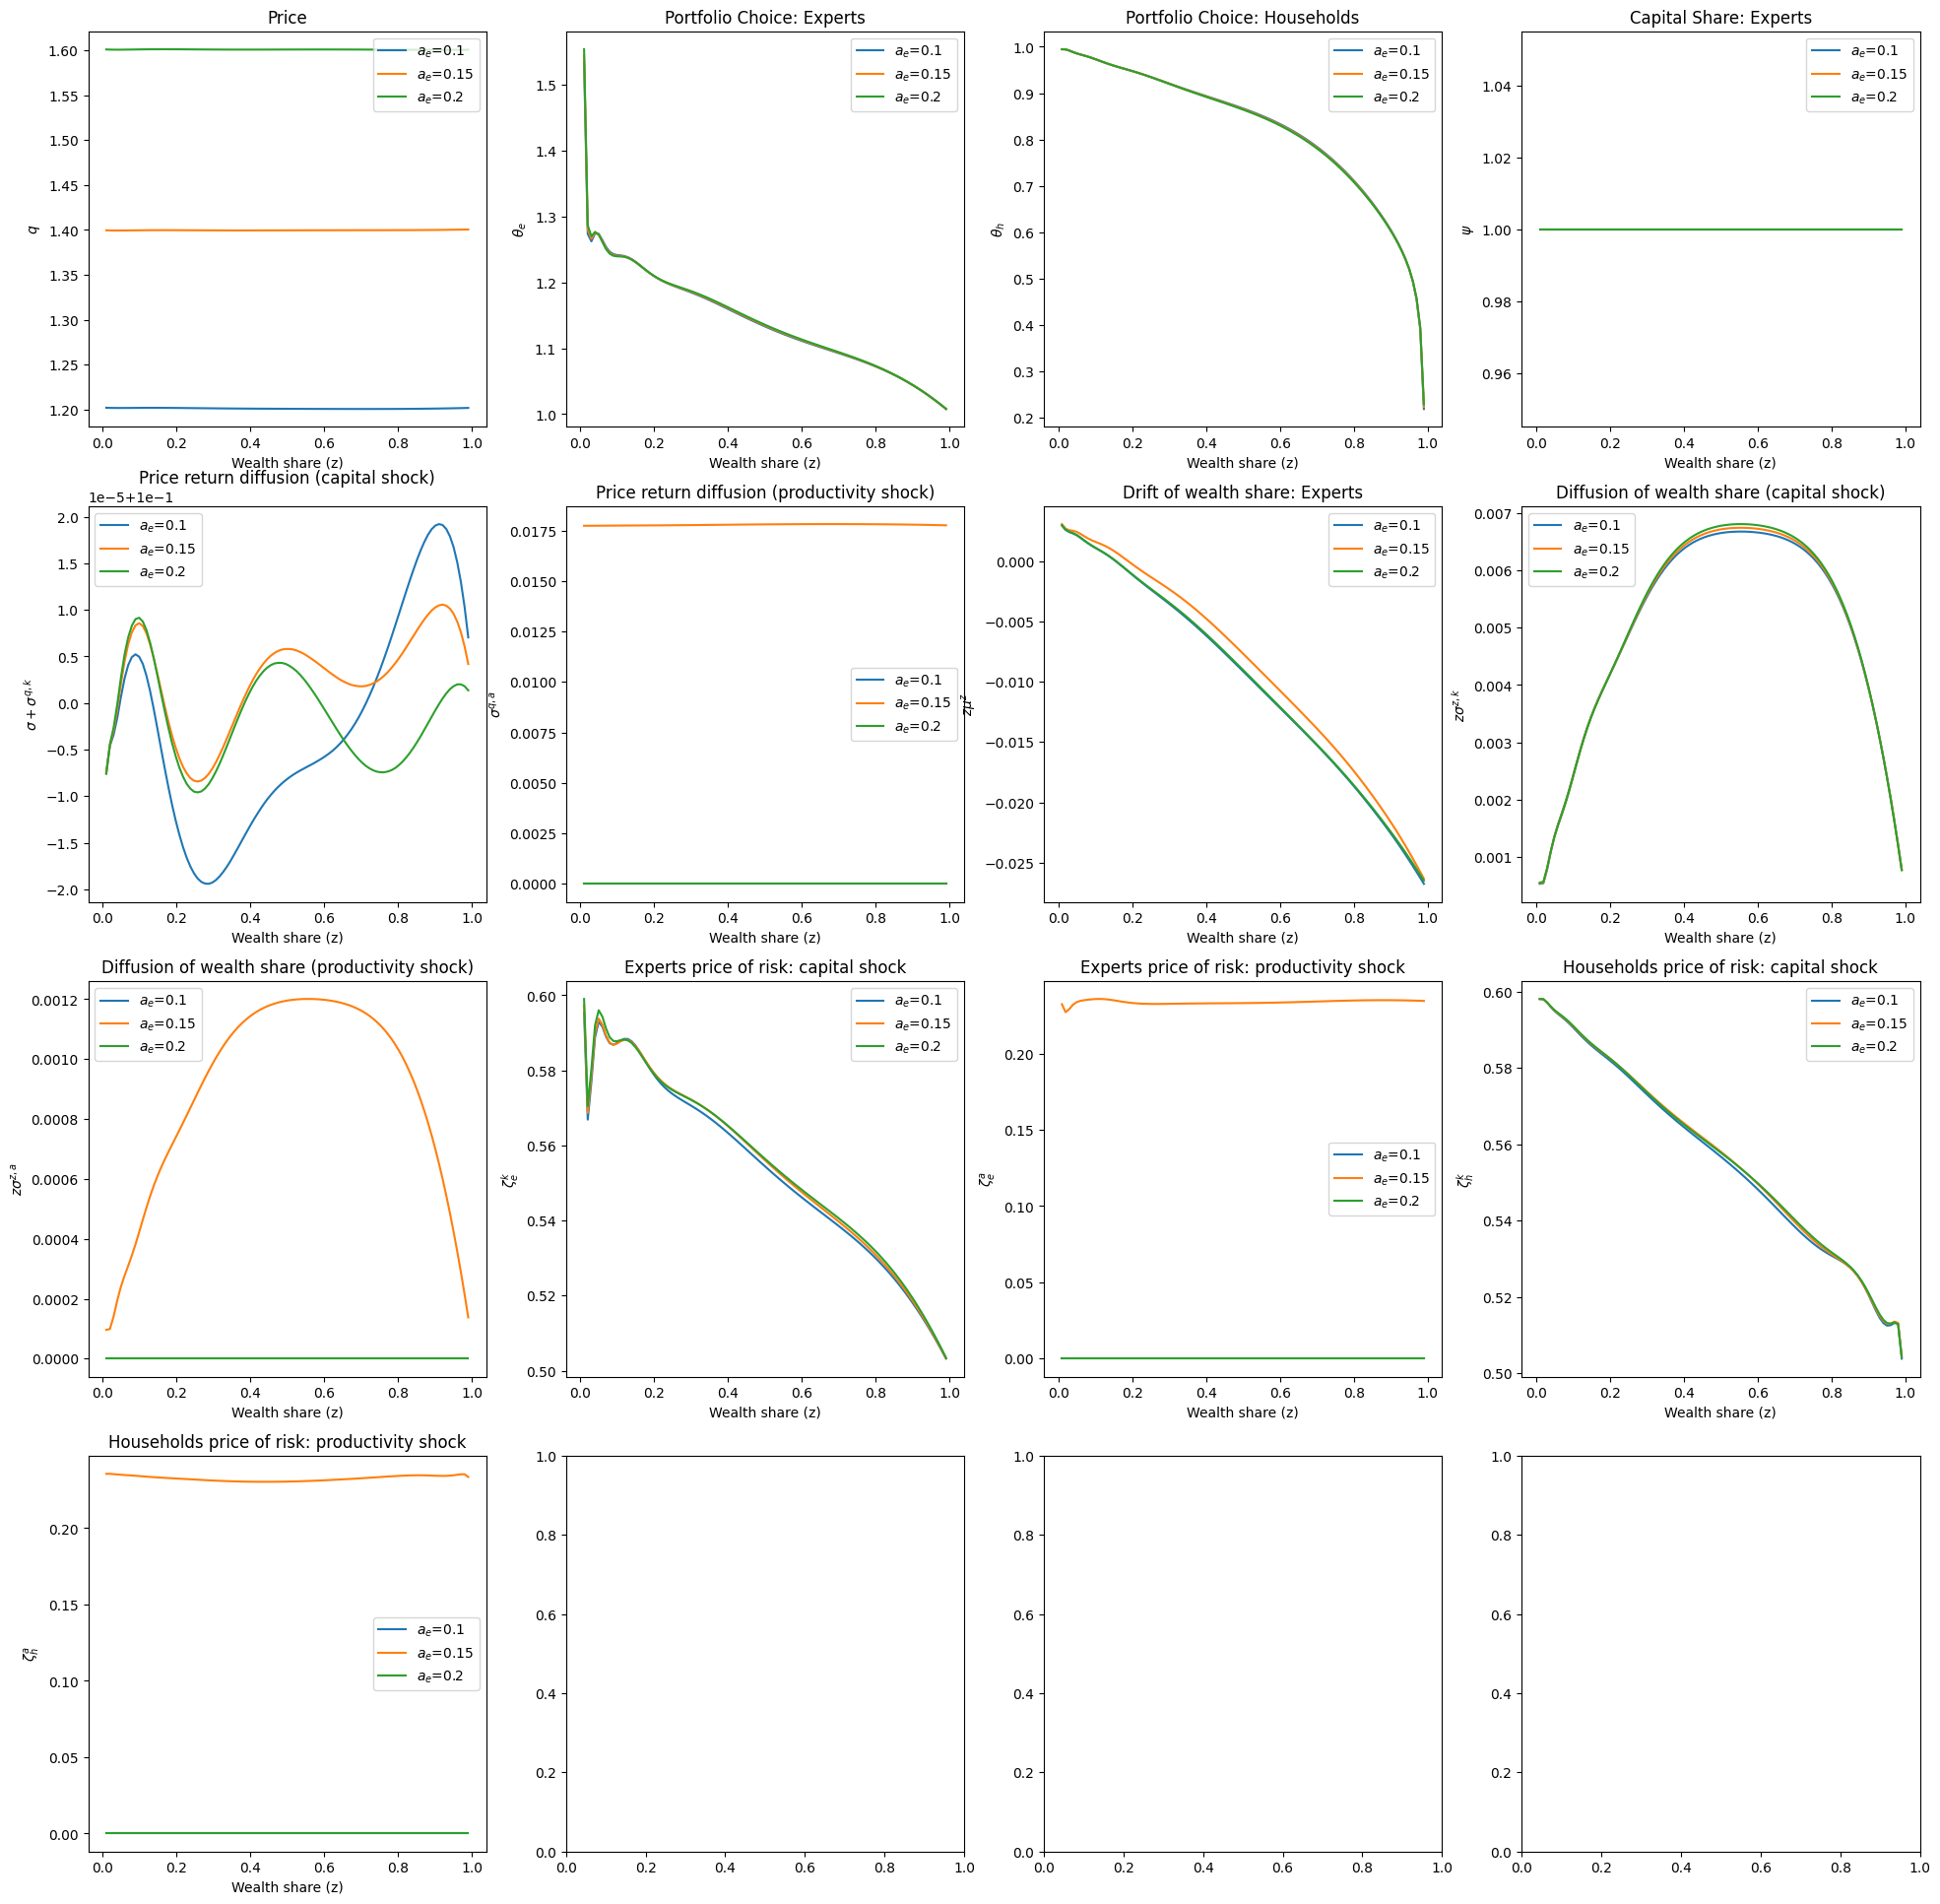

In [ ]:
set_seeds(0)
pde_model = PDEModelTimeStep("cd2d_ts",
                     {"batch_size": 20, "num_outer_iterations": 50, "num_inner_iterations": 5000},
                     latex_var_map)
torch.cuda.empty_cache()
pde_model.set_state(["z", "ae"], {"z": [z_min, z_max], "ae": [a_min, a_max]})
pde_model.add_agents(["Je", "Jh"],
                     {"Je": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "Jh": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                     })
pde_model.add_endogs(["q", "chi"],
                     {"q": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "chi": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4}
                      })
pde_model.add_params(params)

pde_model.add_equation(r"$\iota &= \frac{q - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi &= \frac{\log ( q)}{\kappa}$")
pde_model.add_equation(r"$\hat{c}_e &= \rho$")
pde_model.add_equation(r"$\hat{c}_h &= \rho$")
pde_model.add_equation(r"$\mu_{ae} &= p * (\hat{a_e} - a_e)$")
pde_model.add_equation(r"$\sigma_{ae} &= v * (fu - a_e) * (a_e - fl)$")
pde_model.add_equation(r"$\theta_e &= \frac{\chi}{z}$")
pde_model.add_equation(r"$\theta_h &= \frac{1 - \chi}{1 - z}$")
pde_model.add_equation(r"$\sigma^{q,k} &= \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\chi - z)} - \sigma$")
pde_model.add_equation(r"$\sigma^{q,a} &= \frac{\frac{1}{q} * \frac{\partial q}{\partial a_e} * \sigma_{ae}}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\chi - z)}$")
pde_model.add_equation(r"$\sigma^{q,k,1} &= \sigma + \sigma^{q,k}$")
pde_model.add_equation(r"$\sigma^{z,k} &= \left(\theta_e - 1\right) * \sigma^{q,k,1}$")
pde_model.add_equation(r"$\sigma^{z,a} &= \left(\theta_e - 1\right) * \sigma^{q,a}$")
pde_model.add_equation(r"$\sigma_e^{J,k} &= \frac{1}{J_e} * \frac{\partial J_e}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_h^{J,k} &= \frac{1}{J_h} * \frac{\partial J_h}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_e^{J,a} &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial a_e} * \sigma_{ae} + \frac{\partial J_e}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\sigma_h^{J,a} &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial a_e} * \sigma_{ae} + \frac{\partial J_h}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\zeta_e^k &= -(1-\gamma) * \sigma_e^{J,k} + \sigma^{z,k} + \sigma^{q,k} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_e^a &= -(1-\gamma) * \sigma_e^{J,a} + \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_h^k &= -(1-\gamma) * \sigma_h^{J,k} - \frac{z}{1-z} * \sigma^{z,k} + \sigma^{q,k,1} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_h^a &= -(1-\gamma) * \sigma_h^{J,a} - \frac{z}{1-z} * \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_e^1 &= \zeta_e^k + \phi * \zeta_e^a$")
pde_model.add_equation(r"$\zeta_h^1 &= \zeta_h^k + \phi * \zeta_h^a$")
pde_model.add_equation(r"$\zeta_e^2 &= \zeta_e^a + \phi * \zeta_e^k$")
pde_model.add_equation(r"$\zeta_h^2 &= \zeta_h^a + \phi * \zeta_h^k$")
pde_model.add_equation(r"$\epsilon_e &= \sigma^{q,k,1} * \zeta_e^1 + \sigma^{q,a} * \zeta_e^2$")
pde_model.add_equation(r"$\epsilon_h &= \sigma^{q,k,1} * \zeta_h^1 + \sigma^{q,a} * \zeta_h^2$")
pde_model.add_equation(r"$\mu^z &= \frac{a_e - \iota}{q} - \hat{c}_e+ (\theta_e - 1) * (\sigma^{q,k,1} * (\zeta_e^1 - \sigma^{q,k,1}) + \sigma^{q,a} * (\zeta_e^2 - \sigma^{q,a}) - 2 * \phi * \sigma^{q,k,1} * \sigma^{q,a})+ (1-\chi) * (\sigma^{q,k,1} * (\zeta_e^1 - \zeta_h^1) + \sigma^{q,a} * (\zeta_e^2 - \zeta_h^2)) + \frac{\lambda_d}{z} * (\bar{z} - z)$")
pde_model.add_equation(r"$\mu^q &= \frac{1}{q} * \left( \frac{\partial q}{\partial z} * \mu^z * z + \frac{\partial q}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2 q}{\partial z^2} * z^2 * ((\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k} * \sigma^{z,a})\right)+ \frac{1}{q} * \left( \frac{1}{2} * \frac{\partial^2 q}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 q}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a})  * \sigma_{ae} * z\right)$")
pde_model.add_equation(r"$\mu_e^J &= \frac{\gamma}{2} * ((\sigma_e^{J,k})^2 + (\sigma_e^{J,a})^2 + 2 * \phi * \sigma_e^{J,k} * \sigma_e^{J,a} + \sigma^2) - (\Phi - \delta) + (\gamma - 1) * ( \sigma_e^{J,k} * \sigma + \phi * \sigma * \sigma_e^{J,a}) - \rho * (\log(\rho) - \log(J_e) + \log(z*q))$")
pde_model.add_equation(r"$\mu_h^J &= \frac{\gamma}{2} * ((\sigma_h^{J,k})^2 + (\sigma_h^{J,a})^2 + 2*\phi*\sigma_h^{J,k} * \sigma_h^{J,a} + \sigma^2) - (\Phi-\delta) + (\gamma - 1) * (\sigma_h^{J,k}*\sigma + \phi*\sigma*\sigma_h^{J,a})- \rho * (\log(\rho) - \log(J_h) + \log((1-z)*q))$")
pde_model.add_equation(r"$\mu_e^R &= \frac{a_e - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$\mu_h^R &= \frac{a_h - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$r &= \mu_e^R - \chi * \epsilon_e - (1-\chi) * \epsilon_h$")
pde_model.add_equation(r"zmuz = z * muz")
pde_model.add_equation(r"zsigzk = z * sigzk")
pde_model.add_equation(r"zsigza = z * sigza")

pde_model.add_endog_equation(r"$\rho * q &= a_e - \iota$")
pde_model.add_endog_equation(r"$\epsilon_e &= \epsilon_h$")

pde_model.add_hjb_equation(r"$\frac{\partial J_e}{\partial t} + \frac{\partial J_e}{\partial z} * \mu^z * z + \frac{\partial J_e}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_e}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) +\frac{1}{2} * \frac{\partial^2 J_e}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_e}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_e^J * J_e$")
pde_model.add_hjb_equation(r"$\frac{\partial J_h}{\partial t} + \frac{\partial J_h}{\partial z} * \mu^z * z + \frac{\partial J_h}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_h}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) + \frac{1}{2} * \frac{\partial^2 J_h}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_h}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z - \mu_h^J * J_h$")

print(pde_model)
if not os.path.exists(f"{base_model_dir}/region3.pt"):
    pde_model.train_model(base_model_dir, "region3.pt", True)
    pde_model.load_model(torch.load(f"{base_model_dir}/region3_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{base_model_dir}/region3_best.pt"))
    pde_model.eval_model(True)

res_dict3 = compute_func(pde_model, a_list, z_min, z_max, vars_to_plot)
plot_res(res_dict3, plot_args, a_list)
torch.cuda.empty_cache()

## Final Plots

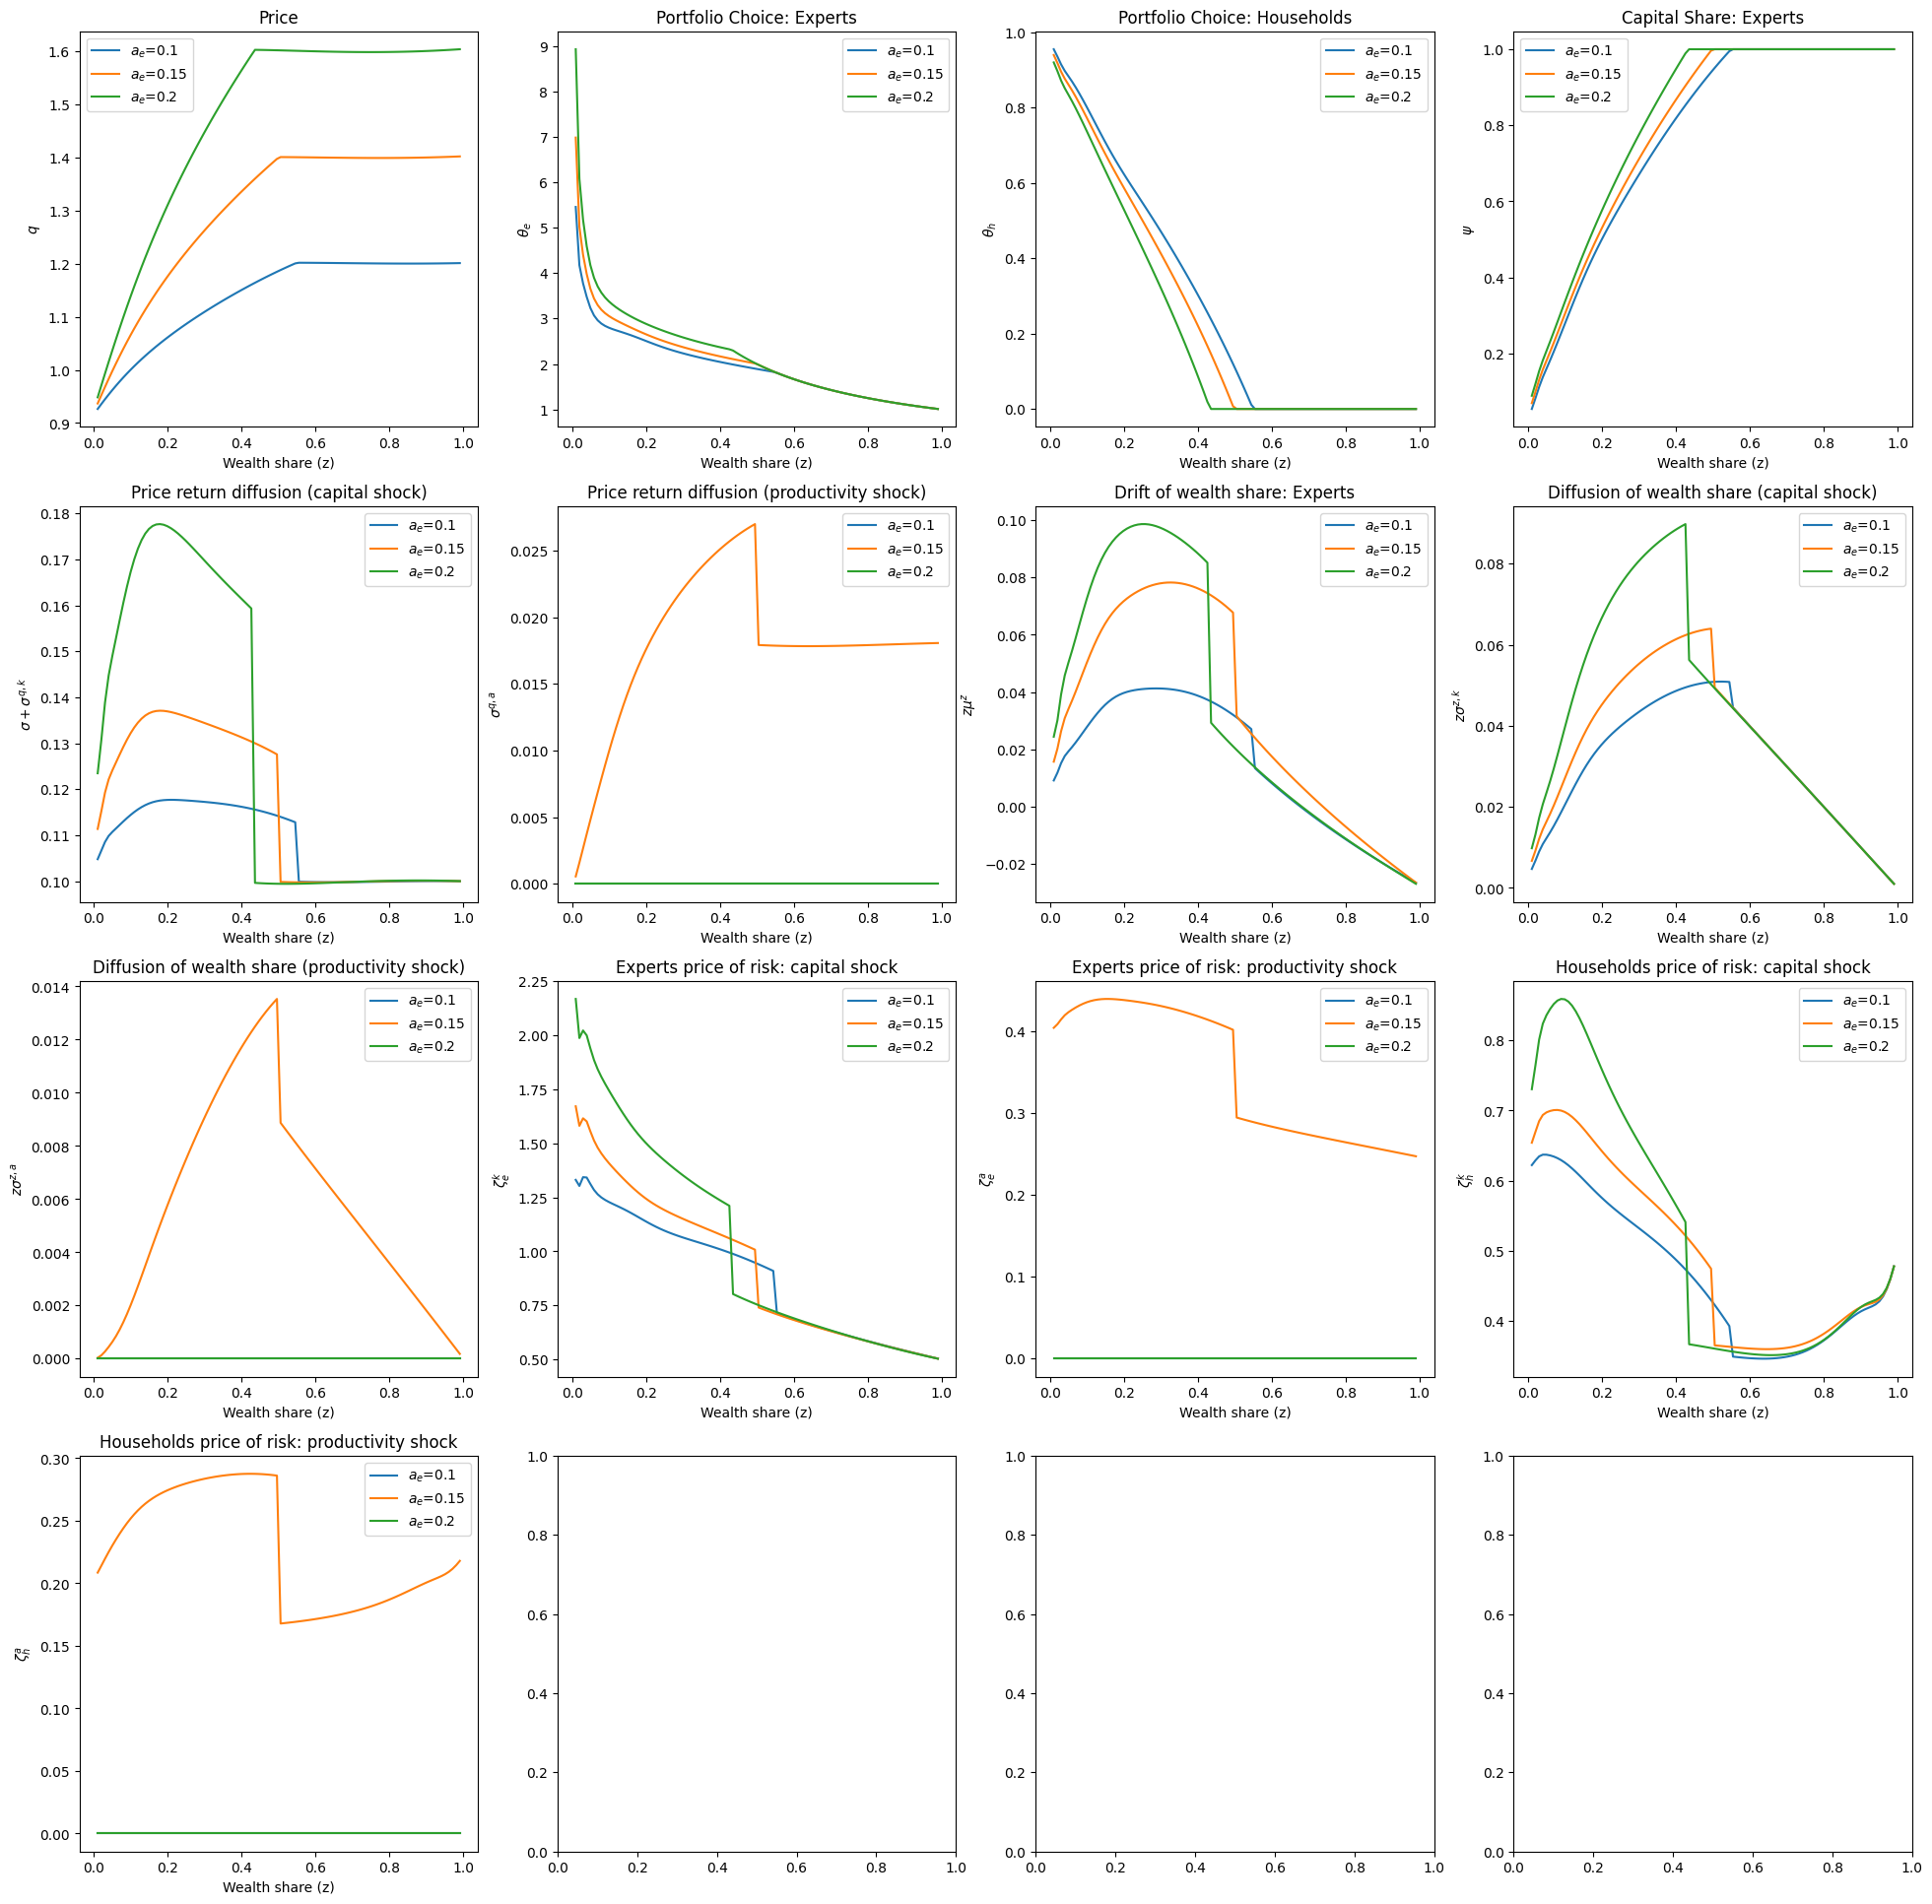

In [ ]:
final_plot_dict = {}
for a in a_list:
    index_region1 = (res_dict1[f"psi_{a}"] < 1)
    index_region2 = (res_dict1[f"psi_{a}"] >= 1) & (res_dict2[f"epse_{a}"] > res_dict2[f"epsh_{a}"])
    index_region3 = (res_dict1[f"psi_{a}"] >= 1) & (res_dict2[f"epse_{a}"] <= res_dict2[f"epsh_{a}"])
    for k in plot_args:
        final_plot_dict[f"{k}_{a}"] = res_dict1[f"{k}_{a}"] * index_region1 + res_dict2[f"{k}_{a}"] * index_region2 + res_dict3[f"{k}_{a}"] * index_region3
final_plot_dict["x_plot"] = res_dict1["x_plot"]
plot_res(final_plot_dict, plot_args, a_list)